## <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 5: Trees, Forests, and Boosting

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



**Partners: Sunil Kumar Shambulingaiah and Steven Devisch** 

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

#@Sunil, added MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<hr style="height:2pt">

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces only other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training observations, {len(data_test)} test observations")
print(data_train.shape[1],"total columns")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training observations, 5000 test observations
29 total columns

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.884,-0.462,0.196,1.330,1.520,1.040,-1.5200,-1.46,2.17,0.361,-2.030,-0.253,0.00,0.337,-0.597,-0.324,2.55,0.493,1.030,-1.1400,0.0,1.450,0.791,1.400,1.250,0.713,0.812,0.821,1.0
1,0.780,-0.292,0.897,0.384,0.413,1.220,-0.4660,-0.92,0.00,1.100,-1.200,1.080,2.21,0.498,1.490,1.060,0.00,0.493,-0.344,-0.0918,0.0,0.812,0.728,0.975,0.637,0.569,0.777,0.715,1.0
2,0.353,-1.070,-1.740,1.170,-0.199,0.558,0.0574,-1.49,1.09,0.912,-1.080,0.571,0.00,0.781,-0.320,-1.040,2.55,0.616,-1.510,1.5500,0.0,0.829,1.060,0.992,0.825,0.365,0.800,0.766,0.0
3,0.757,0.822,-1.290,0.208,-0.151,1.220,-1.6400,1.53,0.00,1.680,0.189,-0.645,0.00,1.780,0.285,0.520,2.55,1.130,-0.932,0.1170,3.1,4.290,2.420,0.995,0.923,0.927,1.760,1.360,1.0
4,2.040,2.030,-0.472,0.424,-1.500,1.060,0.7980,1.22,2.17,0.805,-0.661,-1.460,0.00,0.885,1.440,0.809,0.00,1.290,0.493,-0.0791,3.1,0.895,0.936,1.030,1.560,1.150,1.120,1.160,1.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.986168,0.011449,-0.011057,0.995656,-0.026783,0.990357,0.006779,0.008310,0.999370,0.992922,0.015321,0.010629,1.014648,0.984070,0.017681,-0.012232,0.992122,0.982671,-0.020045,0.017153,0.996650,1.024146,1.023271,1.047602,1.005986,0.972397,1.027461,0.954268,0.529600
std,0.550671,1.015018,1.012867,0.601449,1.012443,0.483224,1.005735,0.992744,1.023674,0.499675,0.994269,1.007182,1.046952,0.478845,1.012092,1.007317,1.198333,0.505908,1.005818,1.020375,1.395097,0.596476,0.352384,0.155067,0.402897,0.515233,0.360030,0.314996,0.499173
min,0.275000,-2.390000,-1.740000,0.014000,-1.740000,0.236000,-2.960000,-1.740000,0.000000,0.190000,-2.870000,-1.740000,0.000000,0.265000,-2.730000,-1.740000,0.000000,0.366000,-2.490000,-1.740000,0.000000,0.161000,0.310000,0.493000,0.445000,0.048100,0.417000,0.448000,0.000000
25%,0.584000,-0.729000,-0.891250,0.569000,-0.901000,0.676000,-0.688250,-0.840000,0.000000,0.661000,-0.688250,-0.859250,0.000000,0.651000,-0.686250,-0.873250,0.000000,0.616000,-0.728000,-0.884500,0.000000,0.791750,0.849000,0.986000,0.766750,0.675000,0.819000,0.767000,0.000000
50%,0.855000,0.013600,-0.023250,0.890000,-0.031950,0.888000,0.012800,0.030100,1.090000,0.890000,0.014150,0.019600,1.110000,0.887000,0.003810,-0.007130,0.000000,0.871000,-0.033800,0.024800,0.000000,0.892000,0.957000,0.990000,0.910000,0.875000,0.941000,0.865000,1.000000
75%,1.230000,0.771000,0.860250,1.290000,0.854000,1.170000,0.702000,0.850250,2.170000,1.210000,0.691250,0.871250,2.210000,1.210000,0.717000,0.863000,2.550000,1.220000,0.714250,0.917250,3.100000,1.030000,1.090000,1.020000,1.130000,1.140000,1.130000,1.050000,1.000000
max,4.960000,2.400000,1.740000,5.510000,1.740000,5.320000,2.960000,1.740000,2.170000,4.930000,2.900000,1.740000,2.210000,5.410000,2.710000,1.740000,2.550000,7.510000,2.500000,1.740000,3.100000,9.280000,5.180000,3.930000,4.800000,5.560000,4.690000,5.990000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

In [6]:
# Standardize the data with a minmax scaler as there are negative values in the data
# scale the datasets
# use minmaxscalar as some predictors are negative
scale_transformer = MinMaxScaler(copy=True).fit(X_train)
X_train = pd.DataFrame(scale_transformer.transform(X_train))
X_test = pd.DataFrame(scale_transformer.transform(X_test))

print(X_train.shape)
pd.DataFrame(X_train).describe()

(5000, 28)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.151797,0.501346,0.496823,0.178613,0.492304,0.148379,0.501145,0.502388,0.460539,0.169393,0.500056,0.503054,0.459117,0.139761,0.505089,0.496485,0.389067,0.086320,0.494981,0.504929,0.321500,0.094654,0.146462,0.161362,0.128814,0.167691,0.142865,0.091351
std,0.117539,0.211903,0.291054,0.109434,0.290932,0.095048,0.169888,0.285271,0.471739,0.105417,0.172317,0.289420,0.473734,0.093070,0.186046,0.289459,0.469934,0.070816,0.201567,0.293211,0.450031,0.065410,0.072358,0.045117,0.092514,0.093476,0.084257,0.056838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.065955,0.346764,0.243894,0.100983,0.241092,0.086546,0.383742,0.258621,0.000000,0.099367,0.378120,0.253089,0.000000,0.075024,0.375689,0.249066,0.000000,0.034994,0.353106,0.245833,0.000000,0.069169,0.110678,0.143439,0.073881,0.113736,0.094079,0.057560
50%,0.123799,0.501795,0.493319,0.159389,0.490819,0.128245,0.502162,0.508649,0.502304,0.147679,0.499853,0.505632,0.502262,0.120894,0.502539,0.497951,0.000000,0.070689,0.492224,0.507126,0.000000,0.080162,0.132854,0.144603,0.106774,0.150021,0.122630,0.075244
75%,0.203842,0.659916,0.747198,0.232169,0.745402,0.183714,0.618581,0.744325,1.000000,0.215190,0.617201,0.750359,1.000000,0.183673,0.633640,0.747989,1.000000,0.119541,0.642134,0.763578,1.000000,0.095296,0.160164,0.153331,0.157290,0.198099,0.166862,0.108625
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Comment**: Note that all features are now scaled from 0 to 1

In [7]:
print(len(data_train))
print(len(data_test))

5000
5000


---

<div class='exercise'><b>Question 1 [25 pts]: Base Modeling </b></div>
We begin by looking at parametric approaches to modeling the Boson data.

**1.1** Calculate the correlation matrix (using `df.corr()` from pandas) between all predictors in the training data set and represent this as a heatmap using (`seaborn.heatmap`).  What does the suggest about the presence of muilticollinearity in the predictor set?

**1.2** Fit a logistic regression model to predict `class` from all 28 of the predictors, and evaluate the model's accuracy on both the training and test sets.

**1.3** Fit a logistic regression model to predict `class` from all 28 of the predictors and all two-way interactions between these predictors (you should have $28+{28 \choose 2} = 406$ columns in the design matrix, ignoring the intercept).  Evaluate the model's accuracy on both the training and test sets.

Hint: you may have to scale your predictors (purely for numerical reasons) and use`maxiter=2000` to avoid the warnings (the next part as well).

**1.4** Use 'L2' regularization on the model in the previous part, tuning the penalty term using 5-fold cross-validation (consider the set of Cs to be [0.01,0.1,1,10,100,1000]).  Which penalty term performed best?  Evaluate the best model's accuracy on both the training and test sets and assign them to variables named `logistic_train_score` and `logistic_test_score`.

**1.5** Compare the performance of the 3 models above.  Which model performs the best on the train set?  Which the best on the test set?  Is this expected?

## Answers:

**1.1** Calculate the correlation matrix (using `df.corr()` from pandas) between all predictors in the training data set and represent this as a heatmap using (`seaborn.heatmap`).  What does the suggest about the presence of muilticollinearity in the predictor set?

Text(0.5, 0.98, 'Correlation matrix between all predictors (red is high correlation)')

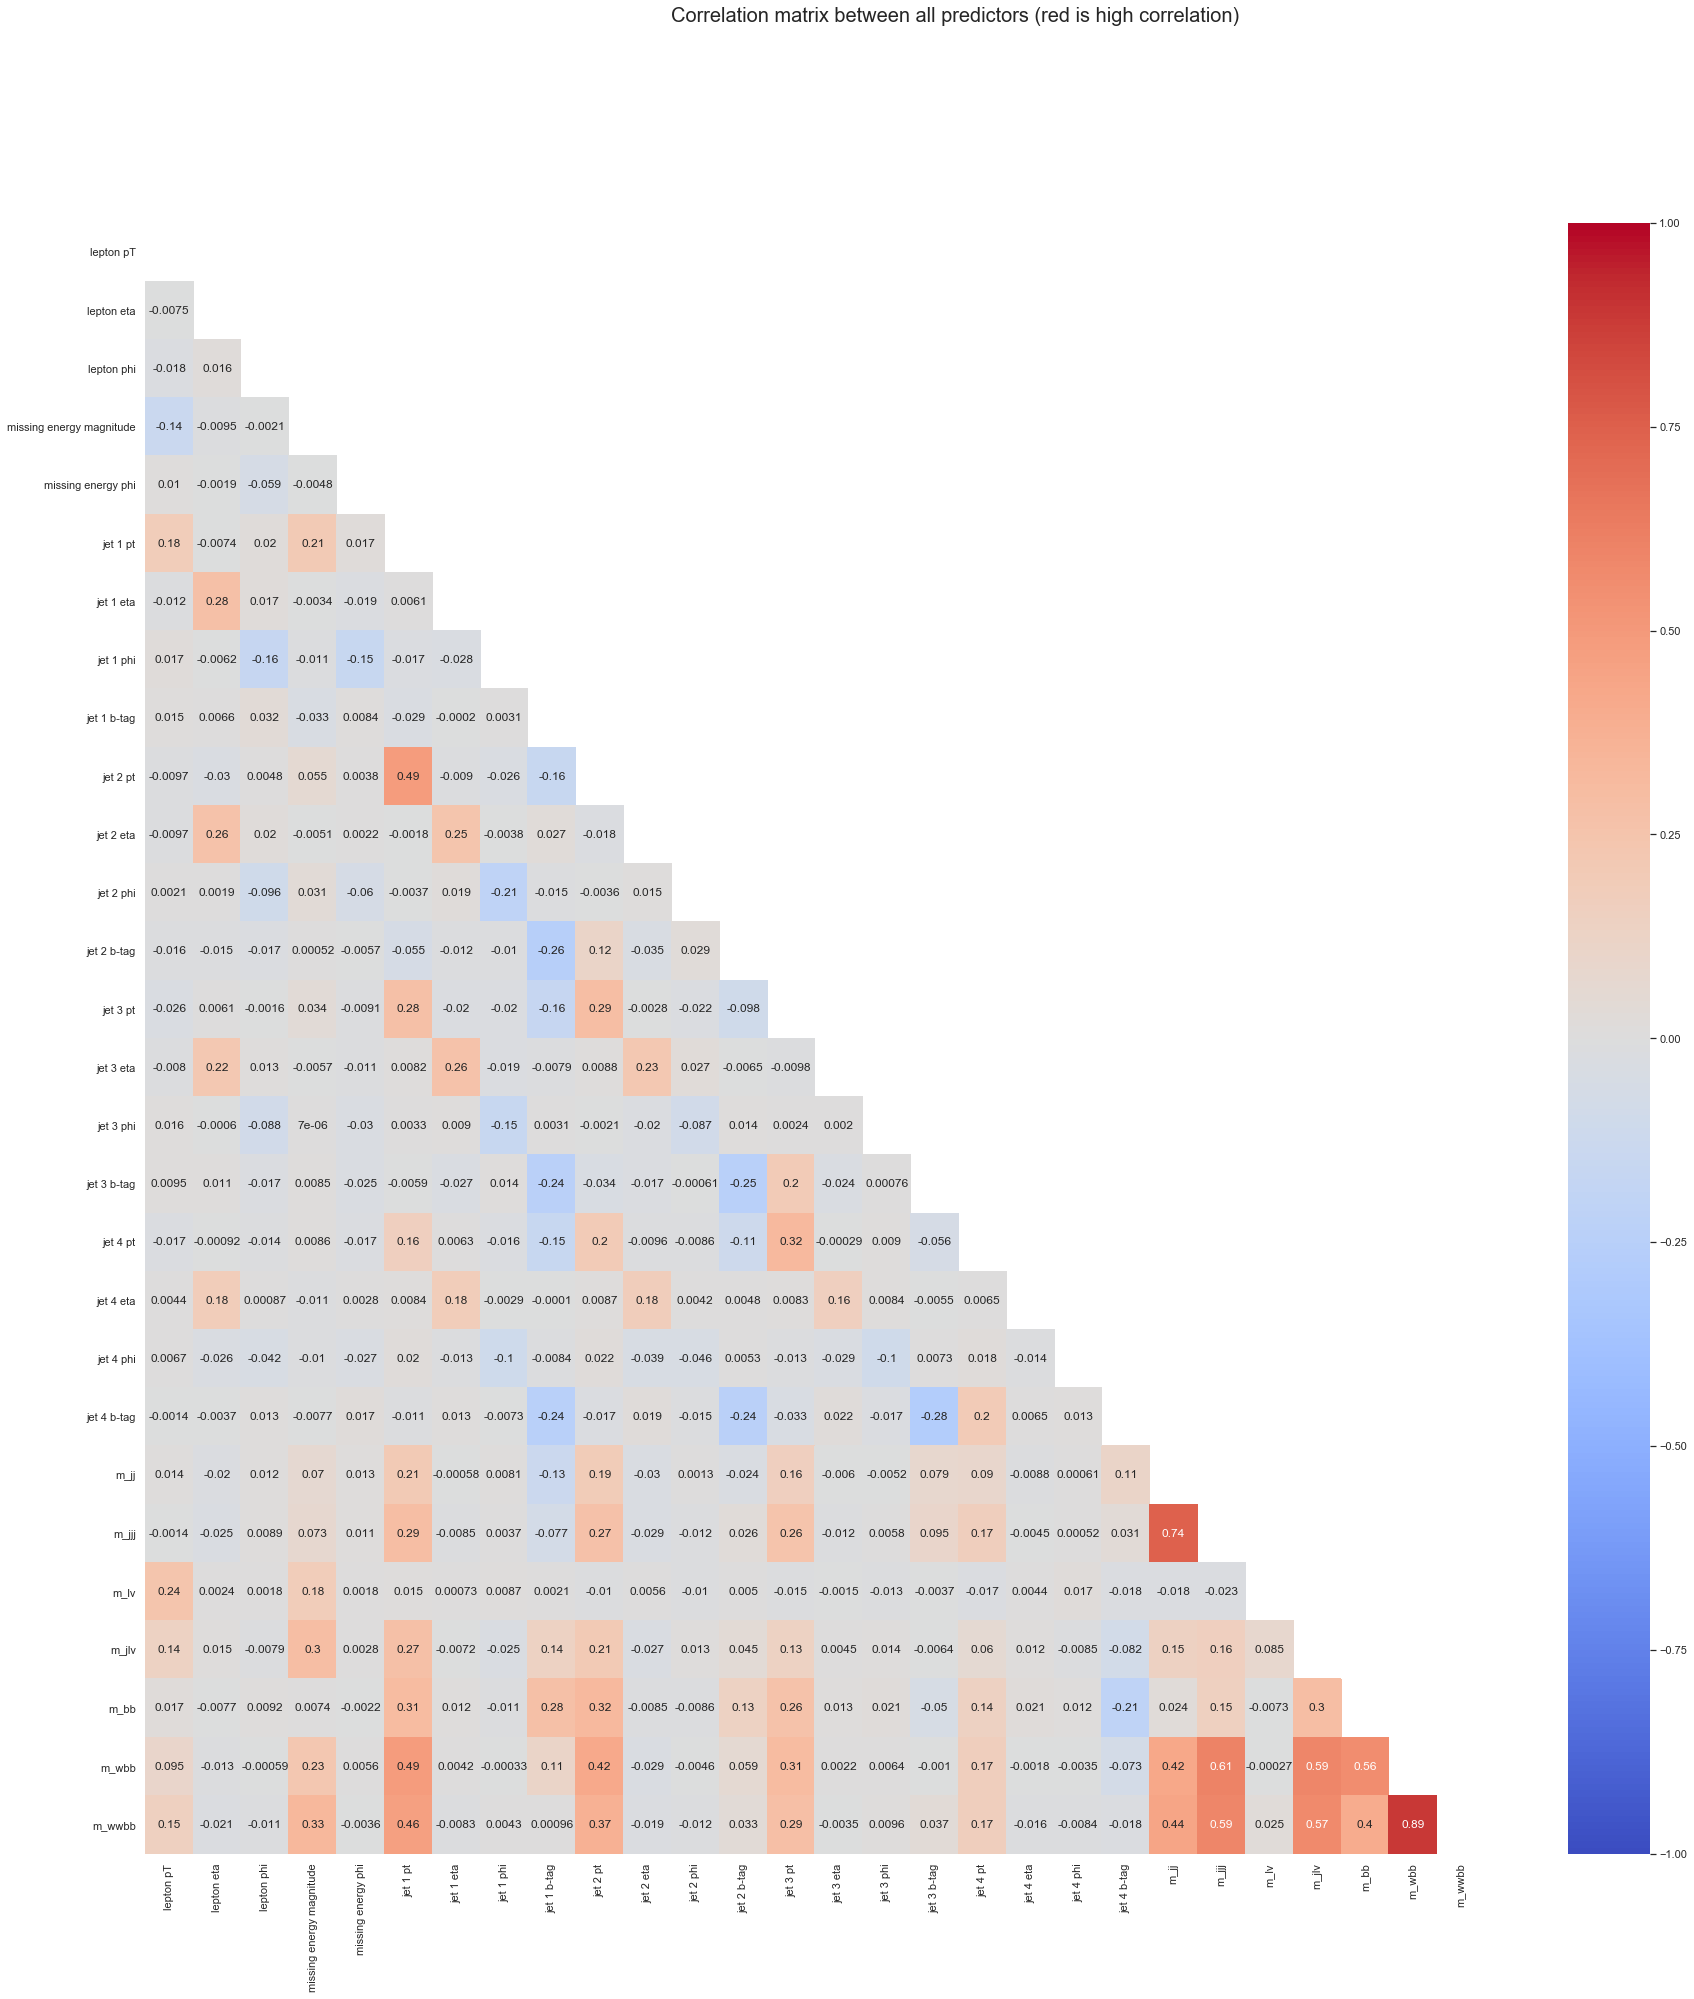

In [8]:
# calculate the correlation matrix
corr = data_train.iloc[:, data_train.columns != 'class'].corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

fig, ax = plt.subplots(figsize=(30,30)) 

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, vmin = -1, vmax = 1, center = 0, mask = mask, 
        ax=ax, annot=True, cmap = 'coolwarm')

fig.suptitle("Correlation matrix between all predictors (red is high correlation)", size=20)

**Comment** : 
There are variables which are strongly corelated. m_wbb, for example, seems highly correlated with multiple variables, and very highly correlated with m_wwbb. It seems reasonable, therefore, to anticipate muilticollinearity. 

**1.2** Fit a logistic regression model to predict `class` from all 28 of the predictors, and evaluate the model's accuracy on both the training and test sets.

In [9]:
# fit the logistic regression without regularization (high c)
logreg = LogisticRegression(solver='liblinear', max_iter=1000, C=100000)
logreg.fit(X_train, y_train)

y_hat_test_logreg = logreg.predict(X_test)
accuracy_test_logreg = accuracy_score(y_test, y_hat_test_logreg)

y_hat_train = logreg.predict(X_train)
accuracy_train_logreg = accuracy_score(y_train, y_hat_train)

In [10]:
print("Accuracy score train:", accuracy_train_logreg, "\nAccuracy score test:", accuracy_test_logreg)

Accuracy score train: 0.6544 
Accuracy score test: 0.629


**1.3** Fit a logistic regression model to predict `class` from all 28 of the predictors and all two-way interactions between these predictors (you should have $28+{28 \choose 2} = 406$ columns in the design matrix, ignoring the intercept).  Evaluate the model's accuracy on both the training and test sets.

Hint: you may have to scale your predictors (purely for numerical reasons) and use`maxiter=2000` to avoid the warnings (the next part as well).

In [11]:
### create the interaction variables
poly = PolynomialFeatures(2, interaction_only=True)

X_train_interaction = poly.fit_transform(X_train)

X_test_interaction = poly.fit_transform(X_test)
print(X_train_interaction.shape)
print(X_test_interaction.shape)

(5000, 407)
(5000, 407)


In [12]:
# fit the model, including the interaction variables 
logreg_interact = LogisticRegression(solver='liblinear', max_iter=2000, C=100000)
logreg_interact.fit(X_train_interaction, y_train)

# calculate accuracy score for the train set
y_hat_train_interact = logreg_interact.predict(X_train_interaction)
cur_accuracy_train_interact = accuracy_score(y_train, y_hat_train_interact)

# calculate accuracy score for the test set
y_hat_test_interact = logreg_interact.predict(X_test_interaction)
cur_accuracy_test_interact = accuracy_score(y_test, y_hat_test_interact)

In [13]:
print("Accuracy score train:", cur_accuracy_train_interact, "\nAccuracy score test:", cur_accuracy_test_interact)

Accuracy score train: 0.7098 
Accuracy score test: 0.6316


**Comment** :
Adding interaction variables does seem to improve the model. Accuracy for the test set is only marginally better. Fitting the models with this many variables is computationaly intensive for a small increase in accuracy.

**1.4** Use 'L2' regularization on the model in the previous part, tuning the penalty term using 5-fold cross-validation (consider the set of Cs to be [0.01,0.1,1,10,100,1000]).  Which penalty term performed best?  Evaluate the best model's accuracy on both the training and test sets. 



In [14]:
from sklearn.linear_model import LogisticRegressionCV

best_accuracy = -1
best_model = None
accuracies = []
c = [0.01,0.1,1,10,100,1000]

# use l2 for lasso and 5 cross validation (cv) folds
logref_l2 =  LogisticRegressionCV(Cs=c, solver='liblinear', penalty='l2', cv=5)
# @Sunil. I would suggest this is also done on standardized features.
# My suggestion would be to standardize at the very beginnign
logref_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100, 1000], class_weight=None, cv=5,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [15]:
logref_l2.scores_[1]

array([[0.552, 0.605, 0.639, 0.651, 0.662, 0.664],
       [0.542, 0.588, 0.609, 0.631, 0.639, 0.639],
       [0.577, 0.606, 0.617, 0.635, 0.64 , 0.644],
       [0.53 , 0.567, 0.59 , 0.626, 0.624, 0.624],
       [0.567, 0.591, 0.629, 0.646, 0.644, 0.645]])

In [16]:
print('Max auc_roc:', logref_l2.scores_[1].mean(axis=0).max()) 

Max auc_roc: 0.6432


In [17]:
cur_accuracy_test_regularized = accuracy_score(y_test, logref_l2.predict(X_test)) 

In [18]:
cur_accuracy_train_regularized = accuracy_score(y_train, logref_l2.predict(X_train))

In [19]:
print("Accuracy score train:", cur_accuracy_train_regularized, "\nAccuracy score test:", 
      cur_accuracy_test_regularized)

Accuracy score train: 0.6544 
Accuracy score test: 0.6286


**Comment** :
The model with 1000 c has the best average Accuracy. 

**1.5** Compare the performance of the 3 models above.  Which model performs the best on the train set?  Which the best on the test set?  Is this expected?

In [20]:
# prepare the index
model_descriptions = ['Logistic', 'Logistic with interacton', 'Regularized logistic']
idx = pd.Index(model_descriptions, name='classifier')

# prepare a dataframe to represent rates for each model
model_comparison_df = pd.DataFrame(
    index=idx,
    columns=['training accuracy', 'test accuracy']
)

# Add rates to dataframe for clear comparison 
# Plain logistic regression
model_comparison_df.loc['Logistic','training accuracy'] = accuracy_train_logreg
model_comparison_df.loc['Logistic','test accuracy'] = accuracy_test_logreg

# Logistic regression with interacton
model_comparison_df.loc['Logistic with interacton','training accuracy'] = cur_accuracy_train_interact
model_comparison_df.loc['Logistic with interacton','test accuracy'] = cur_accuracy_test_interact

# Logistic regression with regularization
model_comparison_df.loc['Regularized logistic','training accuracy'] = cur_accuracy_train_regularized
model_comparison_df.loc['Regularized logistic','test accuracy'] = cur_accuracy_test_regularized

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
classifier,,
Logistic,65.4%,62.9%
Logistic with interacton,71.0%,63.2%
Regularized logistic,65.4%,62.9%


**Comment**: the results are not materially different between the plain logistic regression model, and the regularized model but is better for the model with interaction terms. At the same time test accuracy is not very high. One possibility is that this problem is harder to model using a linear technique. We'll explore a non-linear technique next.

---

<div class='exercise'><b>Question 2 [30 pts]: Tree and Forest Models </b></div>
Our first go to tree-based models, along with our first ensemble methods (bagging and random forests) which we played around with a bit on homework 4.

**2.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.

**2.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

**2.3** Fit a Bagging model using the `X_train` data.  Tune (1) the tree depth from the depths of [5.10.15], and (2) the number of trees from the options [20,50,100].  Evaluate its accuracy on the train and test sets and assign it to variables named `bagging_train_score` and `bagging_test_score`.

**2.4** Fit a `RandomForestClassifier` using the original `X_train` data using the same tree depth and number of trees that you used in the previous question, but tune the number features to consider when looking for the best splits (consider from the list [5,10,15,20,25]). Evaluate its accuracy on the train and test sets and assign it to variables named `random_forest_train_score` and `random_forest_test_score`.

**2.5** Why should the bagging model be tuned to a `max_depth` that is at least as deep as the best single tree depth (from 2.2)?

**2.6**: If you were to run your code again for the bagging and random forest models, would you get the same results?  Why?


## Answers

**2.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.


In [21]:
# Fit a single decision tree stump 
decision_tree_model = DecisionTreeClassifier(max_depth=1)
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_train)

In [22]:
# set number of folds in cross validation
depth_range = range(1,21)
fold_nr = 5

train_scores = []
cvmeans = []
cvstds = []
classifiers = []
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth)
    classifiers.append(clf)
    
    # Perform 5-fold cross validation 
    cv_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=fold_nr, n_jobs=4)

    # store the means and standard deviations
    cvmeans.append((cv_scores.mean()))
    cvstds.append((cv_scores.std()))

    # calculate accuracy on training set
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    train_scores.append(accuracy_score(y_train, y_hat_train))

In [23]:
# calculate the confidence ranges
score_mean_by_depth =  np.array(cvmeans) #convert to array to apply math
score_stdev_by_depth =  np.array(cvstds)
mean_min_stdev = score_mean_by_depth - 2 * score_stdev_by_depth
mean_plus_stdev = score_mean_by_depth + 2* score_stdev_by_depth

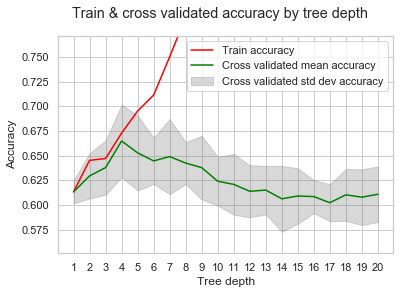

In [24]:

# add accuracy lines for the training scores and cross validated scores
plt.plot(depth_range,train_scores, label='Train accuracy', c='red')
plt.plot(depth_range,score_mean_by_depth, label='Cross validated mean accuracy', c='green')

# set the y axis range to focus on cross validation
plt.ylim(mean_plus_stdev.min()-.07,mean_plus_stdev.max()+.07)
plt.fill_between(depth_range, 
                  mean_min_stdev, 
                  mean_plus_stdev, alpha=0.3, color='gray', label='Cross validated std dev accuracy')

# Make figure readable
plt.suptitle("Train & cross validated accuracy by tree depth")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(depth_range);

In [25]:
best_cv_mean = cvmeans.index(max(cvmeans))
print("The most appopriate trees depth is:", best_cv_mean + 1)

The most appopriate trees depth is: 4


**Comment**: Note how the accuracy on the training set keeps increasing as tree depth increases, while the cross validated version produces a more reasonable result. Average cross validated accuracy goes down as depth increases. "4" seems to be a reasonable tree depth.

**2.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

In [26]:
print("The most appopriate single decision tree depth is:", cvmeans.index(max(cvmeans)) + 1)

The most appopriate single decision tree depth is: 4


In [27]:
# select and the best model
best_model = classifiers[best_cv_mean]
best_model.fit(X_train, y_train)

# train predictions
y_hat_train = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_hat_train)

# test prediction
y_hat_test = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_hat_test)

In [28]:
# Add to comparison table
model_comparison_df.loc['Single tree','training accuracy'] = best_cv_tree_train_score
model_comparison_df.loc['Single tree','test accuracy'] = best_cv_tree_test_score

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
classifier,,
Logistic,65.4%,62.9%
Logistic with interacton,71.0%,63.2%
Regularized logistic,65.4%,62.9%
Single tree,67.3%,63.5%


**Comment:** The single decision tree model does only marginally better than any of the other models. But under perfomances slightly compared with Logistic with interacton model.



**2.3** Fit a Bagging model using the `X_train` data.  Tune (1) the tree depth from the depths of [5.10.15], and (2) the number of trees from the options [20,50,100].  Evaluate its accuracy on the train and test sets and assign it to variables named `bagging_train_score` and `bagging_test_score`.

In [29]:
# prepare a dataframe to represent rates for each model
bagging_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [30]:
from sklearn.metrics import r2_score

bagging_train_score = -1
bagging_test_score = -1
depth_option = 7
tree_nr_options = [20,50,100]
depth_options = [5, 10, 15]

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for i in range(ntrees):
            estimators = []
            R2s_train = []
            R2s_test = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            simpletree = DecisionTreeClassifier(max_depth=depth_option)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,simpletree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,simpletree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,simpletree.score(X_test, y_test))
            y_hats_test[:,i] = simpletree.predict(X_test)

            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option)
            bagging_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            bagging_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            # retain the best scores
            if R2s_test > bagging_test_score:
                bagging_test_score = np.mean(R2s_test)
                bagging_train_score = np.mean(R2s_train)

In [31]:
# display the rates by model in percentage format
bagging_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
20 bagged trees w/ depth 5,68.2%,62.7%
50 bagged trees w/ depth 5,68.5%,63.6%
100 bagged trees w/ depth 5,66.5%,61.9%
20 bagged trees w/ depth 10,79.2%,61.6%
50 bagged trees w/ depth 10,80.1%,62.1%
100 bagged trees w/ depth 10,78.9%,60.4%
20 bagged trees w/ depth 15,84.6%,61.0%
50 bagged trees w/ depth 15,85.0%,60.0%
100 bagged trees w/ depth 15,83.7%,60.1%


**Comment:** Training accuracy goes up as we add  depth, but reaches maximum at 50 trees. Based on test accuracy, however, the best classifier has depth 5, with 20 bagged trees.

In [32]:
# Add best tree to comparison table
model_comparison_df.loc['Bagging','training accuracy'] = bagging_train_score
model_comparison_df.loc['Bagging','test accuracy'] = bagging_test_score

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
classifier,,
Logistic,65.4%,62.9%
Logistic with interacton,71.0%,63.2%
Regularized logistic,65.4%,62.9%
Single tree,67.3%,63.5%
Bagging,69.7%,65.6%


**Comment:** Test accuracy is slightly increasing after bagging.

**2.4** Fit a `RandomForestClassifier` using the original `X_train` data using the same tree depth and number of trees that you used in the previous question, but tune the number features to consider when looking for the best splits (consider from the list [5,10,15,20,25]). Evaluate its accuracy on the train and test sets and assign it to variables named `random_forest_train_score` and `random_forest_test_score`.




In [33]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [34]:
# prepare a dataframe to represent rates for each model
random_forest_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [35]:

from sklearn.metrics import r2_score

random_forest_train_score = -1
random_forest_test_score = -1
depth_option = 7
tree_nr_options = [20,50,100]
depth_options = [5, 10, 15]
max_features_list = [5,10,15,20,25]

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for max_features in max_features_list:
            estimators = []
            R2s_train = []
            R2s_test = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            randomtree = RandomForestClassifier(max_depth=depth_option, max_features = max_features)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,randomtree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,randomtree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,randomtree.score(X_test, y_test))
            
            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option) + " and max_features " + str(max_features)
            random_forest_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            random_forest_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            # retain the best scores
            if R2s_test > random_forest_test_score:
                random_forest_test_score = np.mean(R2s_test)
                random_forest_train_score = np.mean(R2s_train)
                best_tree_nr = ntrees
                best_depth = depth_option
                best_max_features = max_features
                


In [36]:
print("The best tree number is:", best_tree_nr)
print("The best tree depth is:", depth_option)
print("The best max_features is:", best_max_features)

The best tree number is: 100
The best tree depth is: 15
The best max_features is: 15


In [37]:
# Add best tree to comparison table
model_comparison_df.loc['Random forest','training accuracy'] = random_forest_train_score
model_comparison_df.loc['Random forest','test accuracy'] = random_forest_test_score

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
classifier,,
Logistic,65.4%,62.9%
Logistic with interacton,71.0%,63.2%
Regularized logistic,65.4%,62.9%
Single tree,67.3%,63.5%
Bagging,69.7%,65.6%
Random forest,87.7%,68.9%


**Comment:** Random forest accuracy is slightly better than the other models.

**2.5** Why should the bagging model be tuned to a `max_depth` that is at least as deep as the best single tree depth (from 2.2)?



As we demonstrated, a single decision tree tends to overfit as tree depth goes up. A bagged model, however, averages the predictions for a large number of trees. This adds resilience to the prediction, reducing variance, even is bias is higher. As such, it is reasonable put max_depth at least as high for bagging models.

**2.6**: If you were to run your code again for the bagging and random forest models, would you get the same results?  Why?


@Sunil. Please check this. 
Paper https://www.jmlr.org/papers/volume9/biau08a/biau08a.pdf describes how bagging models produce consistent results. The reason for this consistency is the consistency of averaging rules: by averaging enough, we get consistent results.

---

<div class='exercise'><b> Question 3 [30 pts]: Boosting </div>
In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**3.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**3.2** Use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree with `max_depth=3` as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**3.3** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**3.4** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

**3.5** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**3.6** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

## Answers

**3.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [38]:
# Fit a single decision tree at depth = 3 
tree1 = DecisionTreeClassifier(max_depth=3)
tree1.fit(X_train, y_train)

y_hat_train_tree1 = tree1.predict(X_train)
accuracy_train_tree1 = accuracy_score(y_train, y_hat_train_tree1)

y_hat_test_tree1 =  tree1.predict(X_test)
accuracy_test_tree1 = accuracy_score(y_test, y_hat_test_tree1)

print("Train accuracy for tree1:", accuracy_train_tree1)
print("Test accuracy for tree1:", accuracy_test_tree1)


Train accuracy for tree1: 0.647
Test accuracy for tree1: 0.6392


In [39]:
train_accuracy = y_train == y_hat_train_tree1
test_accuracy = y_test == y_hat_test_tree1

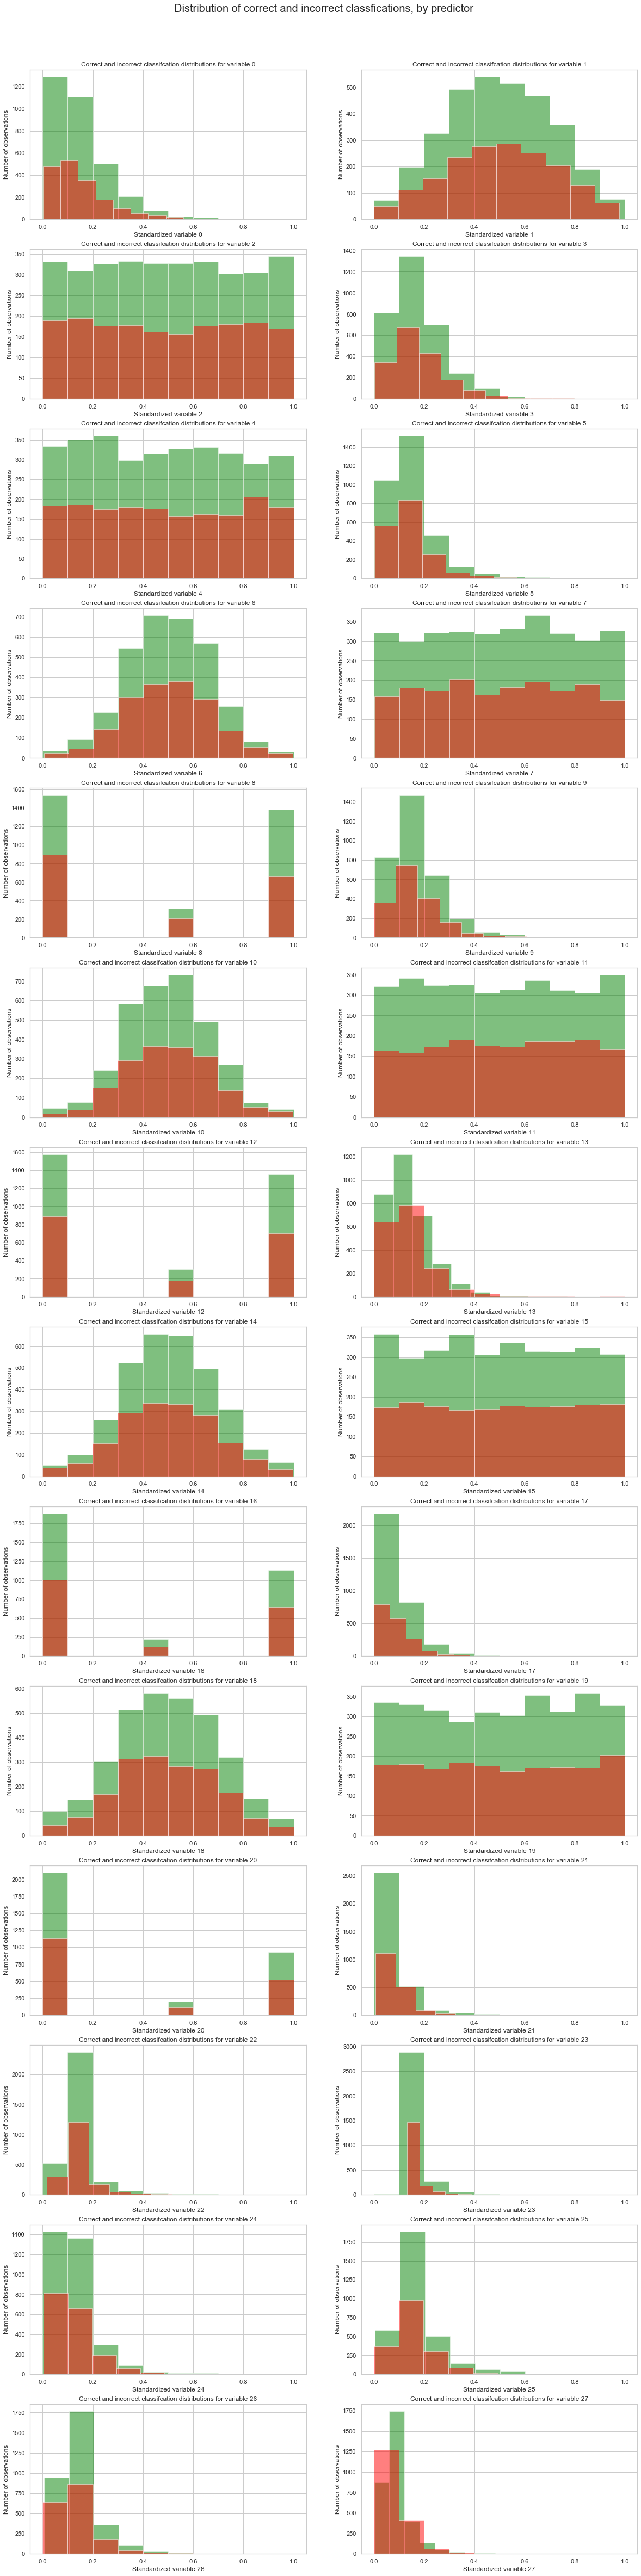

In [40]:
ncol = 2
nrow = np.int(X_train.shape[1] / ncol)
fig,ax = plt.subplots(nrow,ncol,figsize = (20,nrow*6))
axes = ax.ravel()

fig.suptitle("Distribution of correct and incorrect classfications, by predictor", size=20, y=0.9)
for k, ax in enumerate(axes):
    ax.hist(X_train[k][train_accuracy == True], color="green", alpha=0.5, label = "Correct classifications")
    ax.hist(X_train[k][train_accuracy == False], color="red", alpha=0.5, label = "Incorrect classifications")
    ax.set_xlabel("Standardized variable " + str(k))
    ax.set_ylabel("Number of observations")
    ax.set_title("Correct and incorrect classifcation distributions for variable " + str(k))
    ax.legend

**Comment:** the distribution for correctly classified and wrongly classified examples, looks very similar for most predictors, with the exception of predictor 27.
@Sunil it seems strange they ask to look at this if there are few things to notice


variable 23, 27, 17, 13, 9

In [52]:
result_data_df = X_train.copy()
result_data_df['result'] = y_train == y_hat_train_tree1
result_data_df.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
                          '16', '17','18', '19', '20', '21', '22', '23', '24', '25', '26', '27','result']

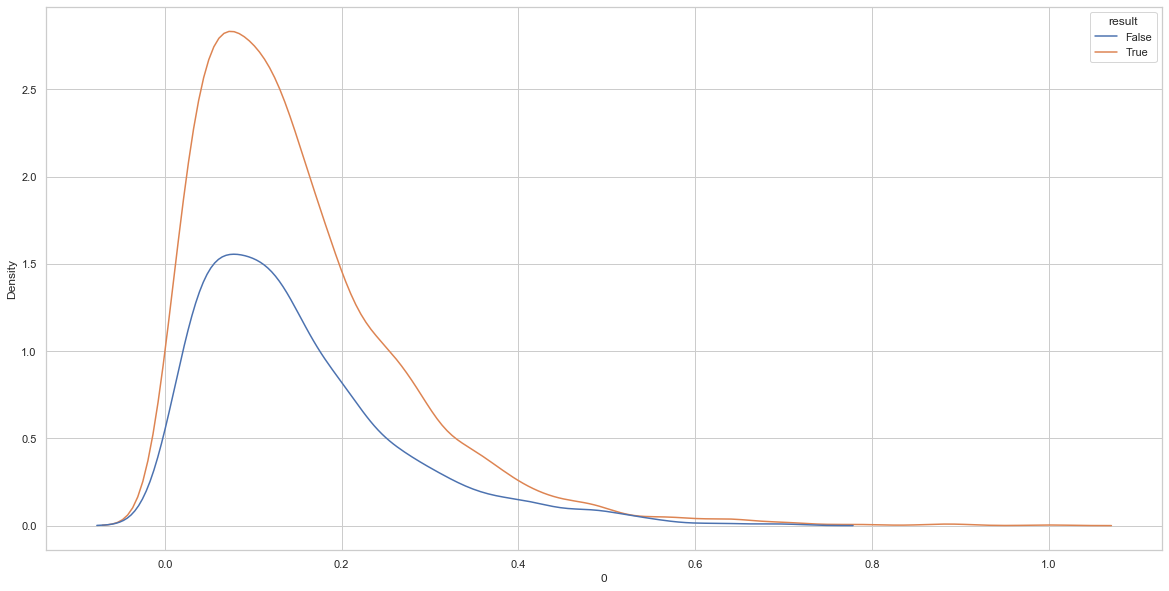

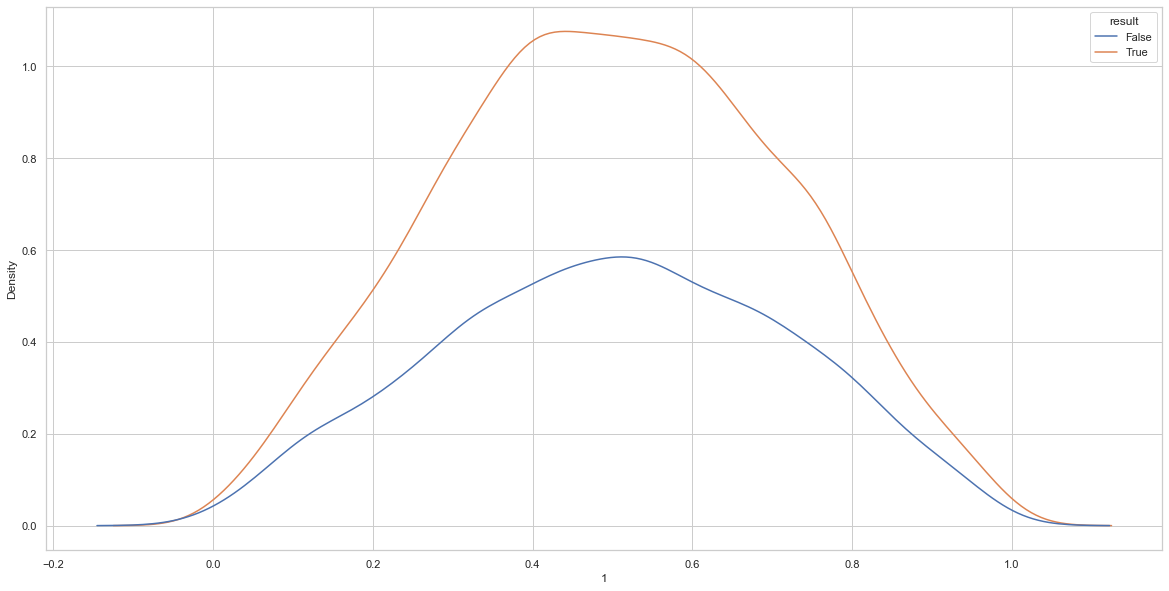

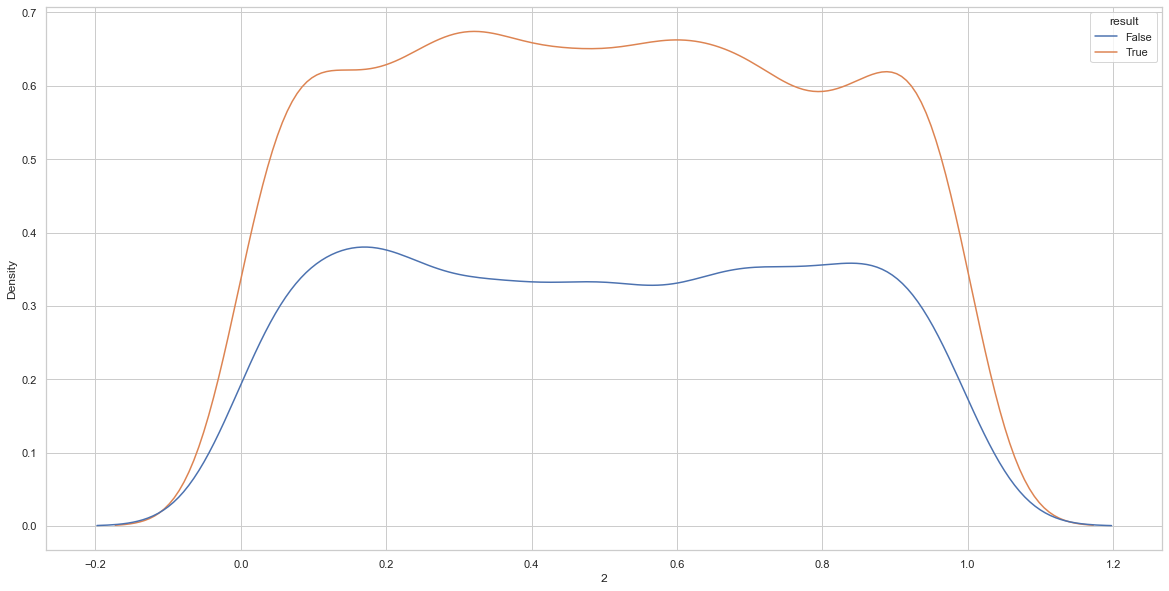

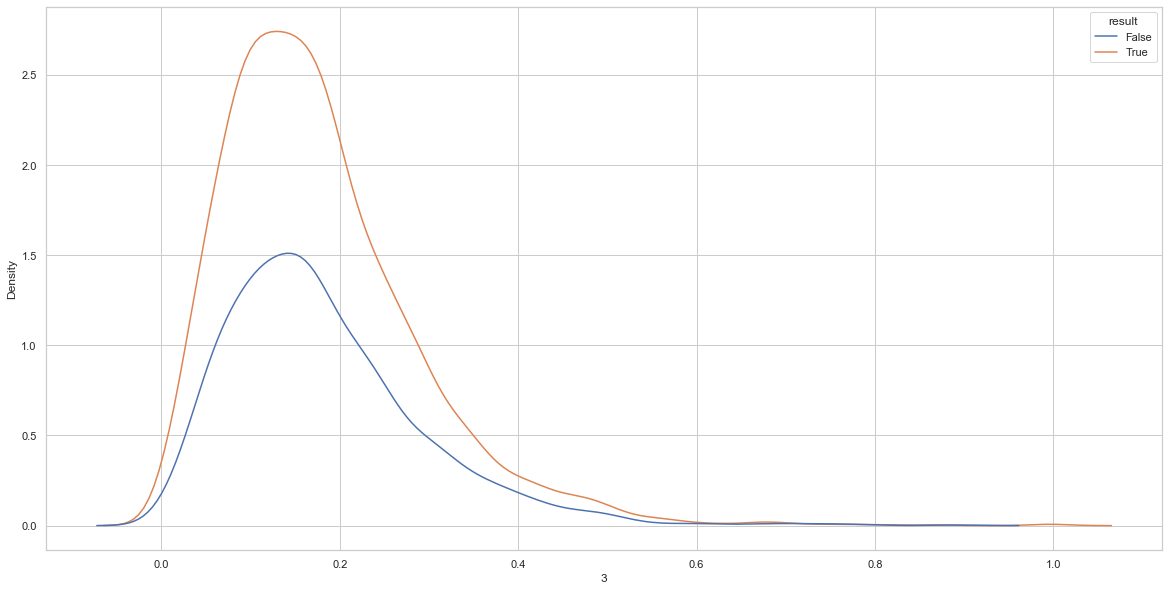

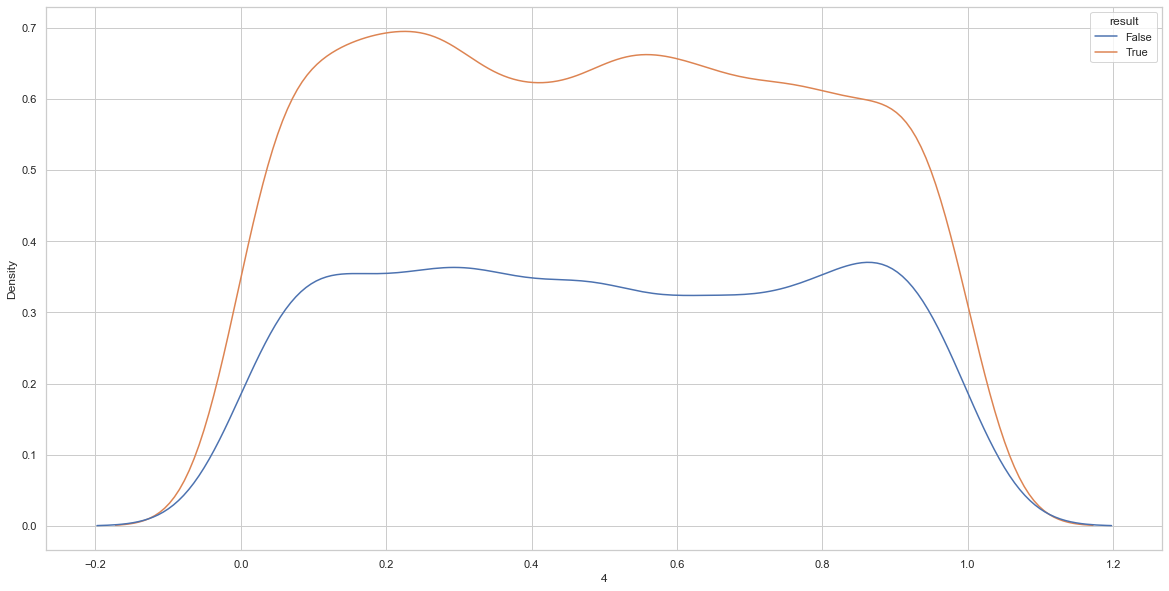

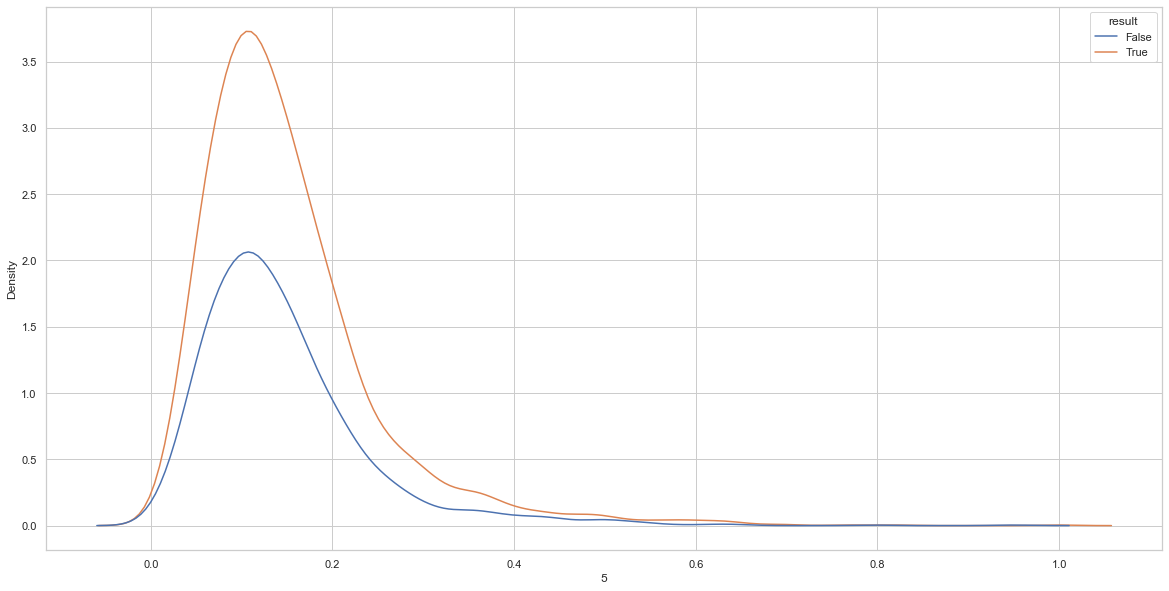

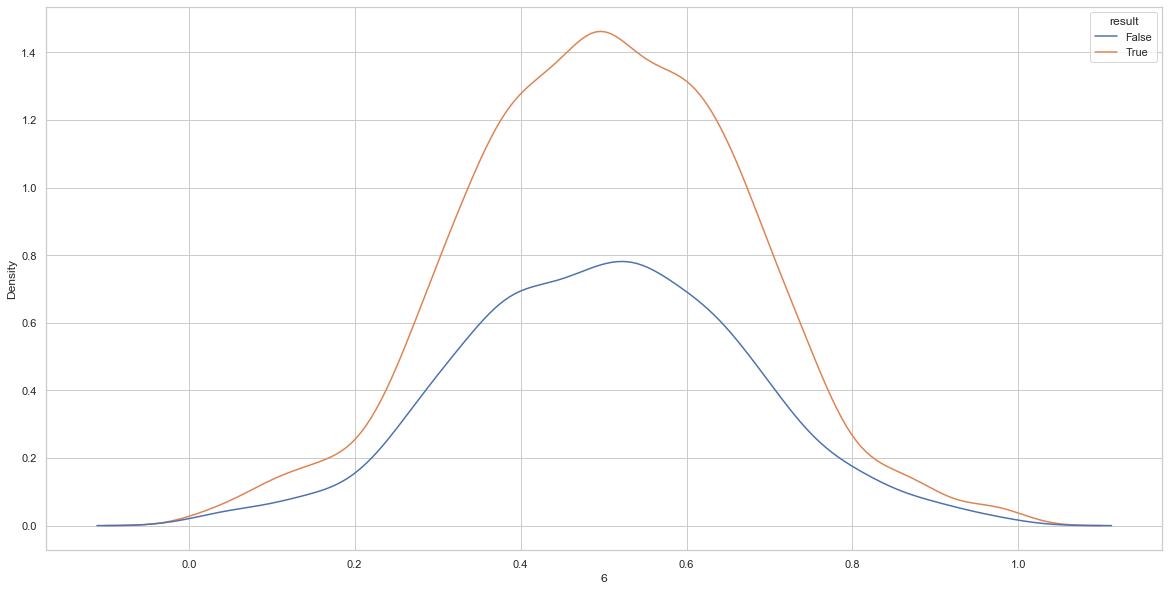

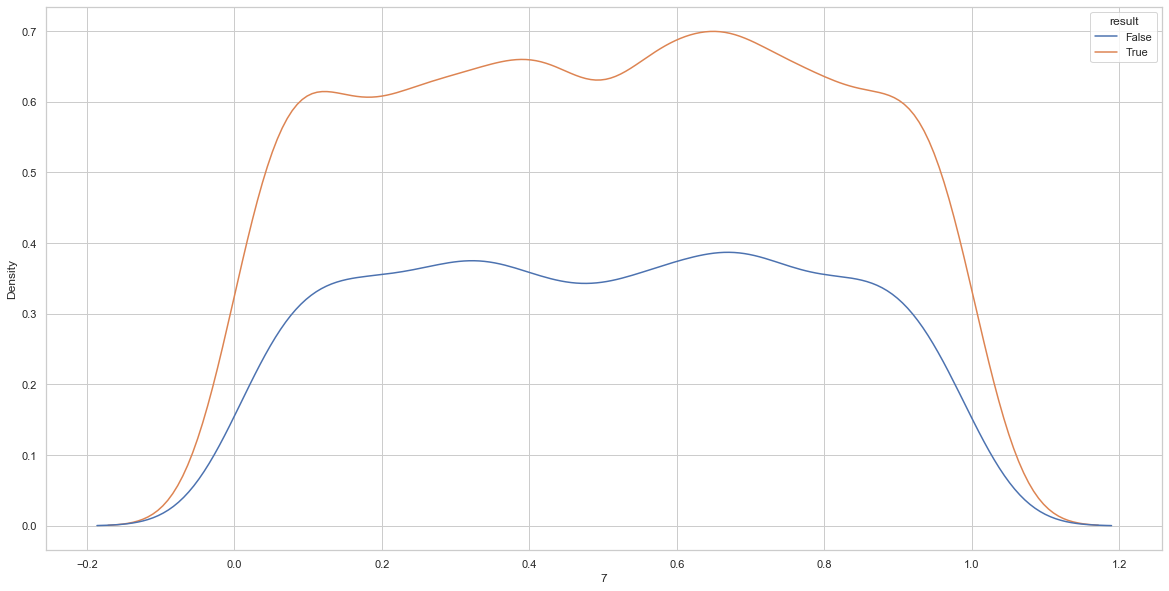

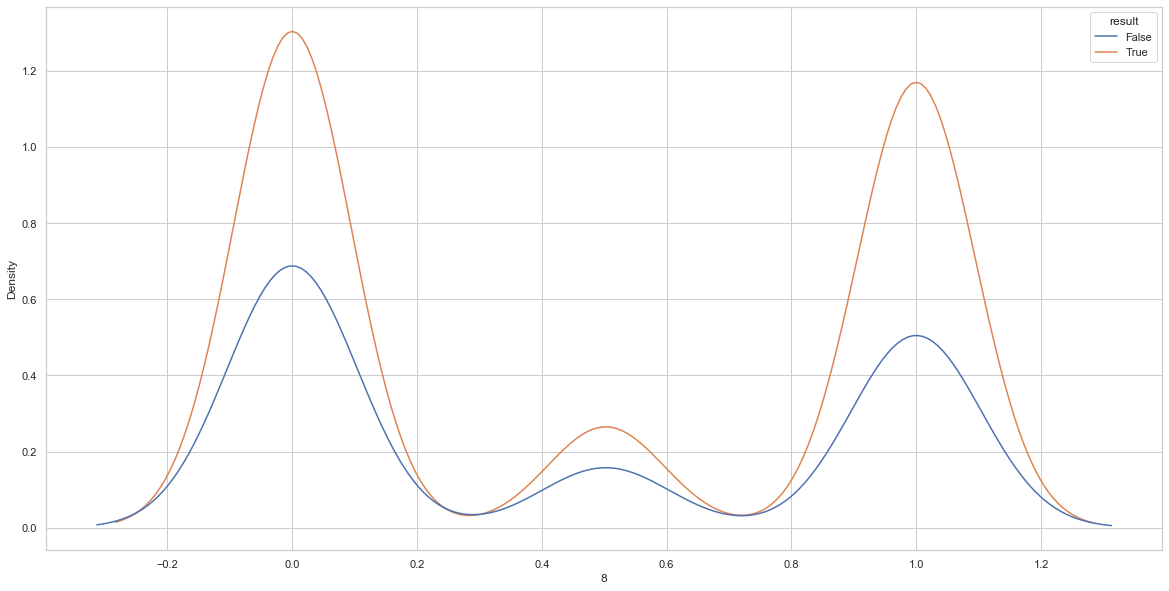

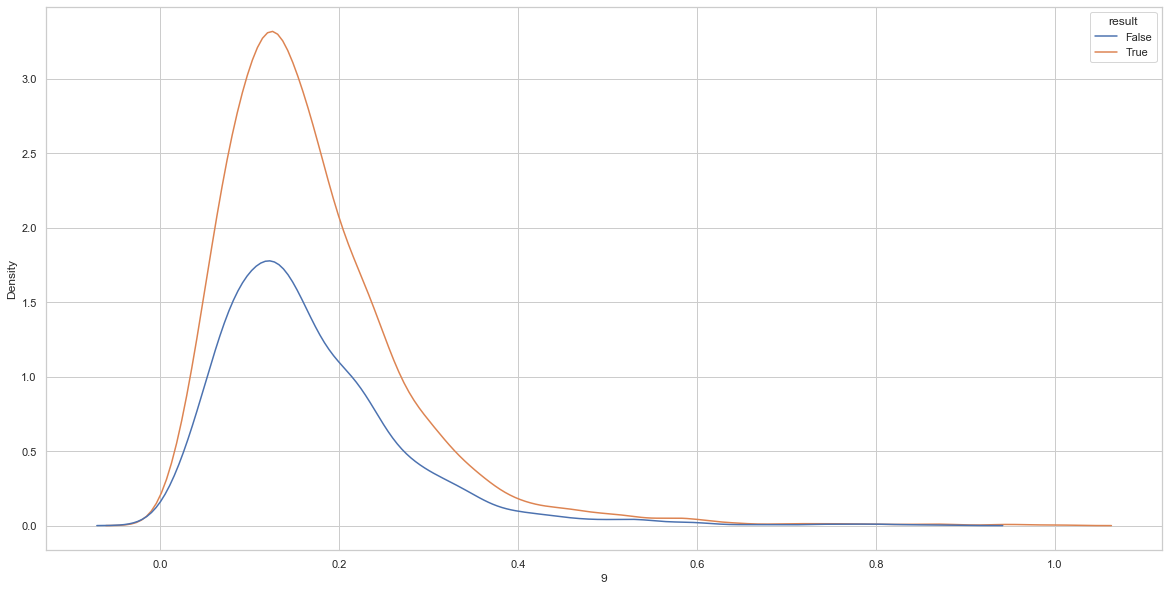

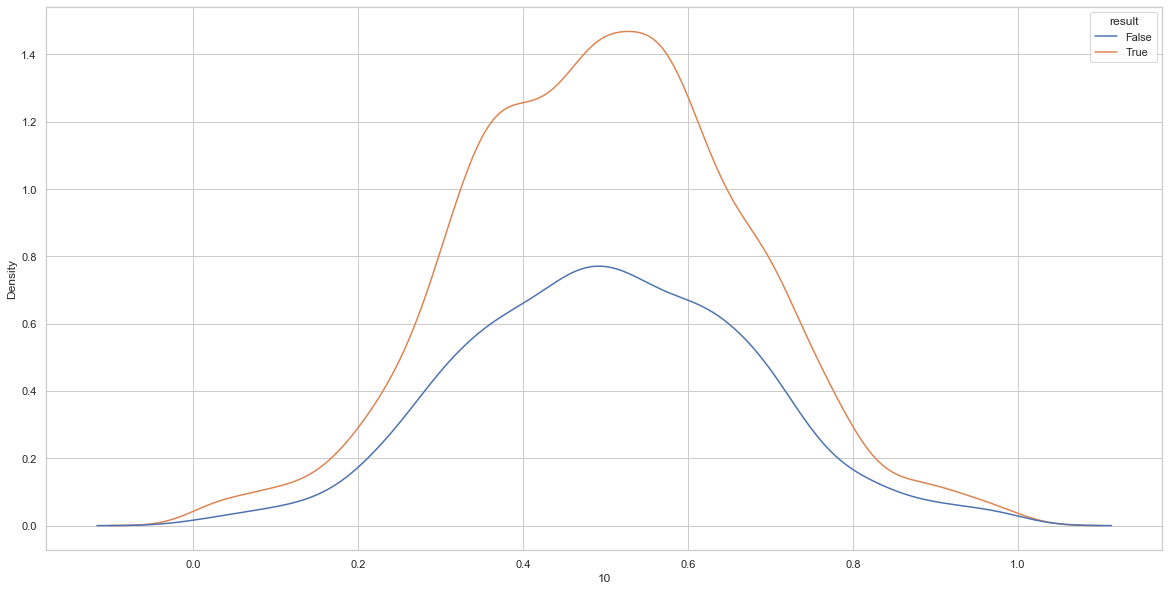

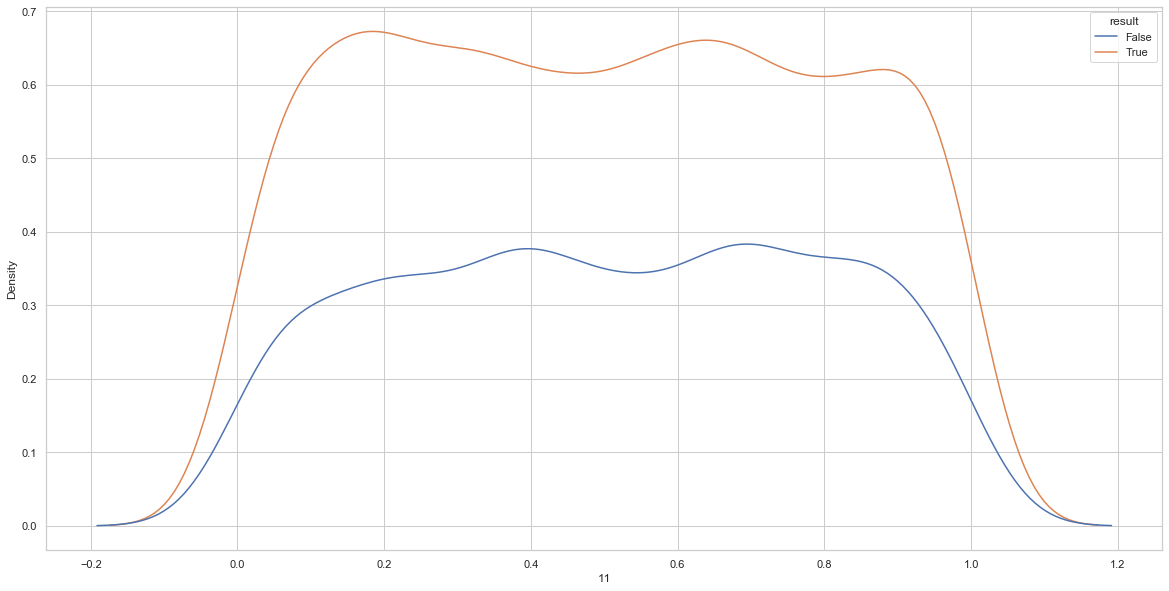

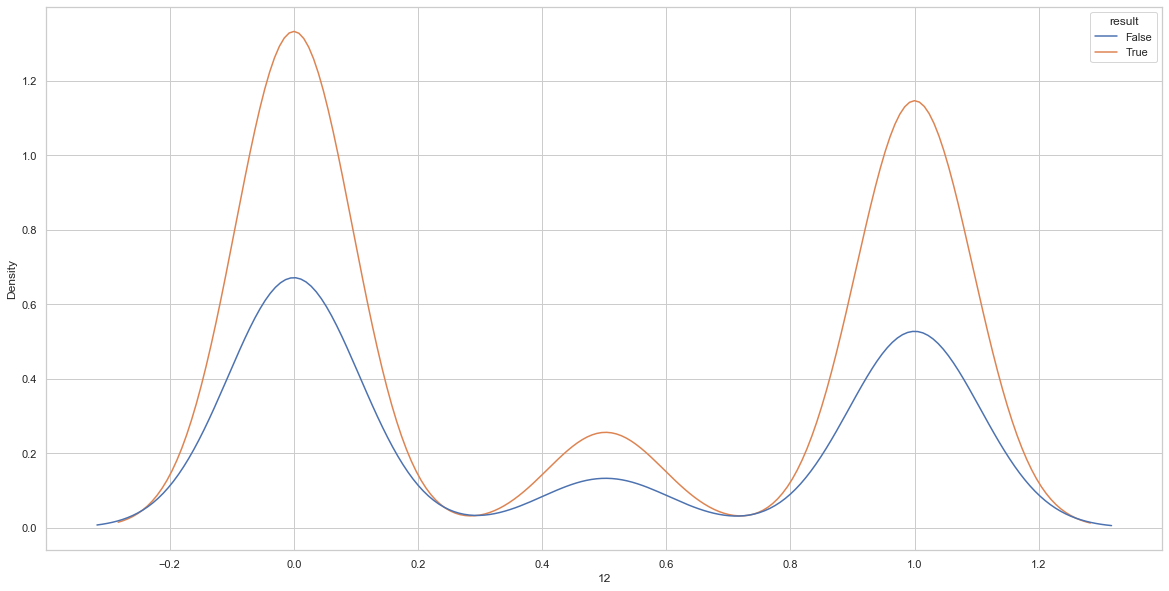

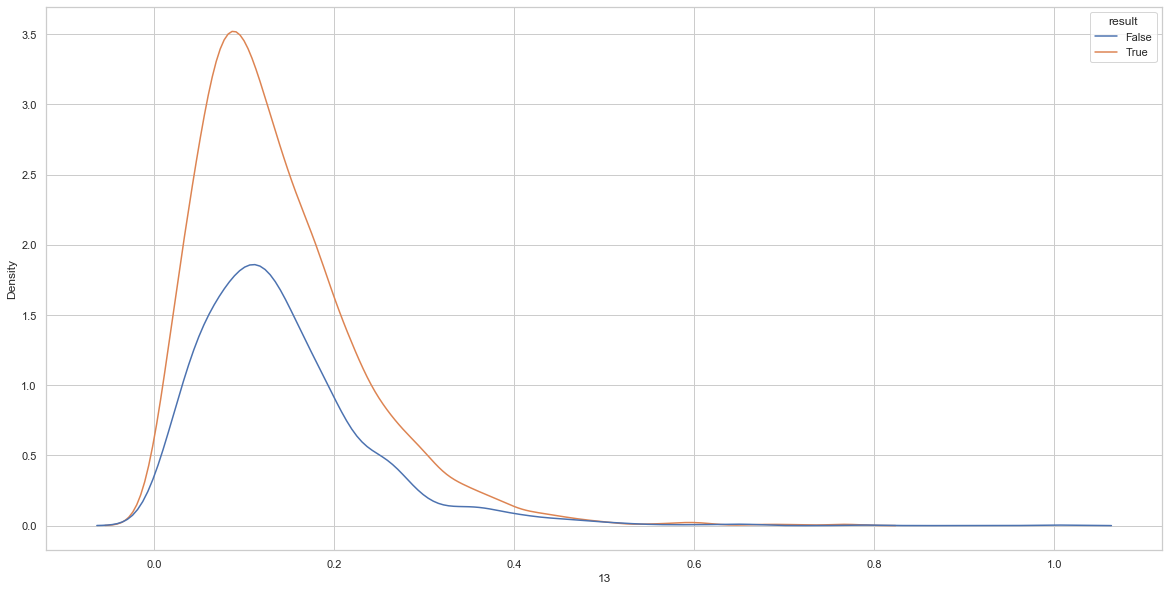

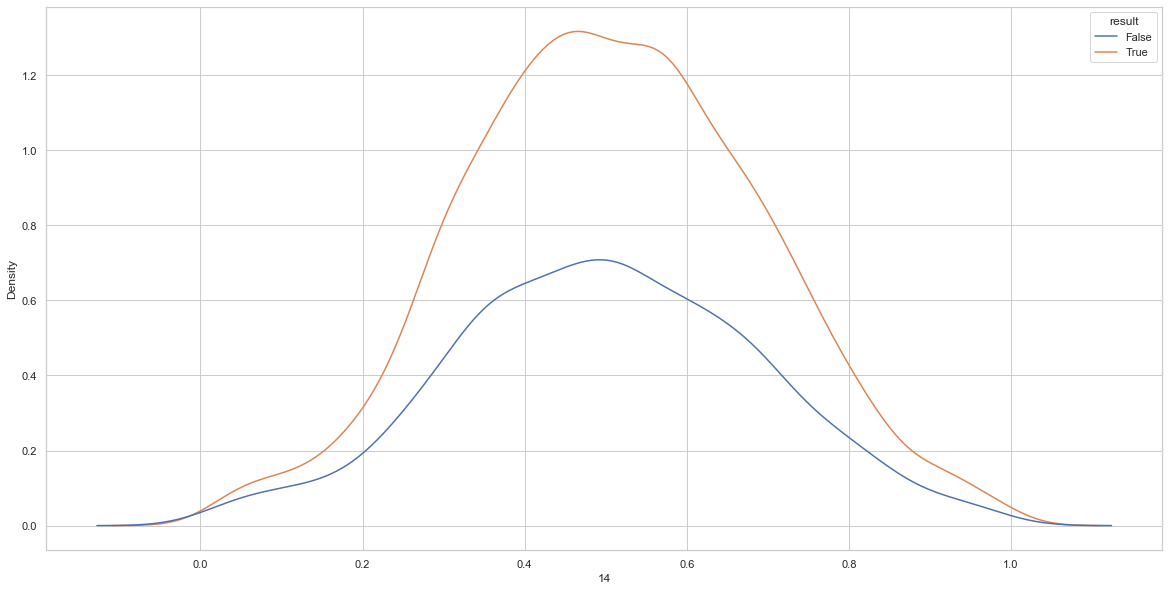

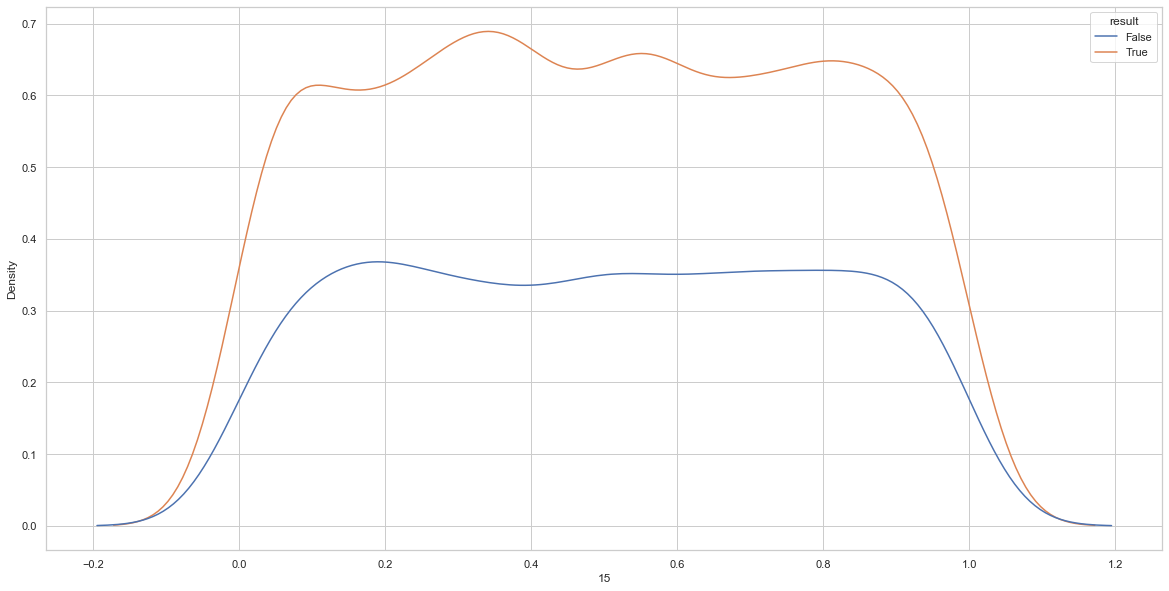

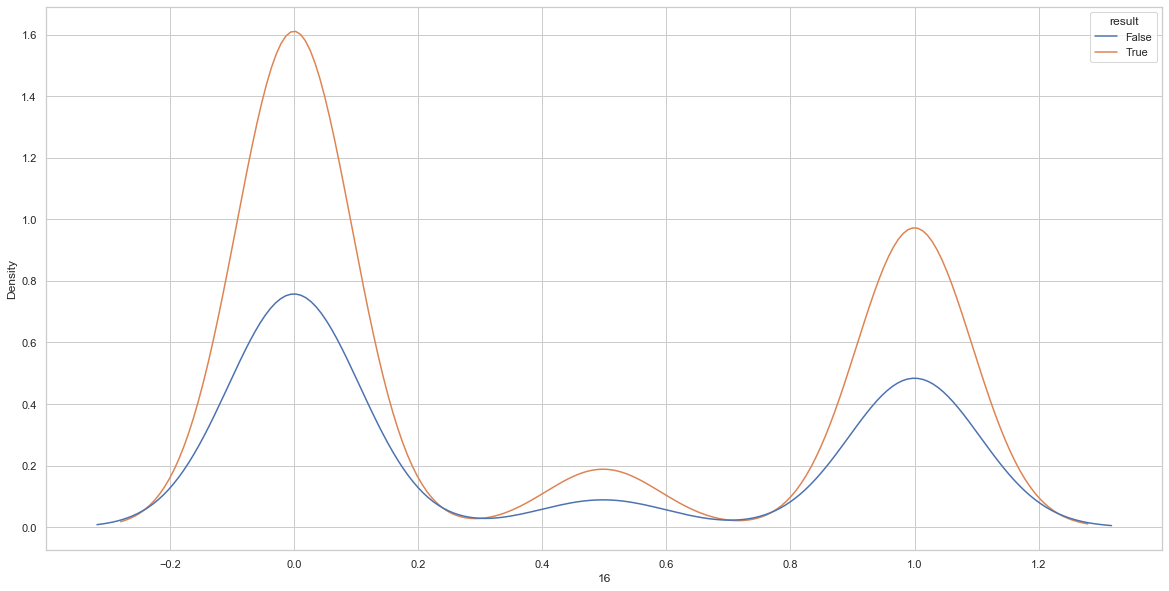

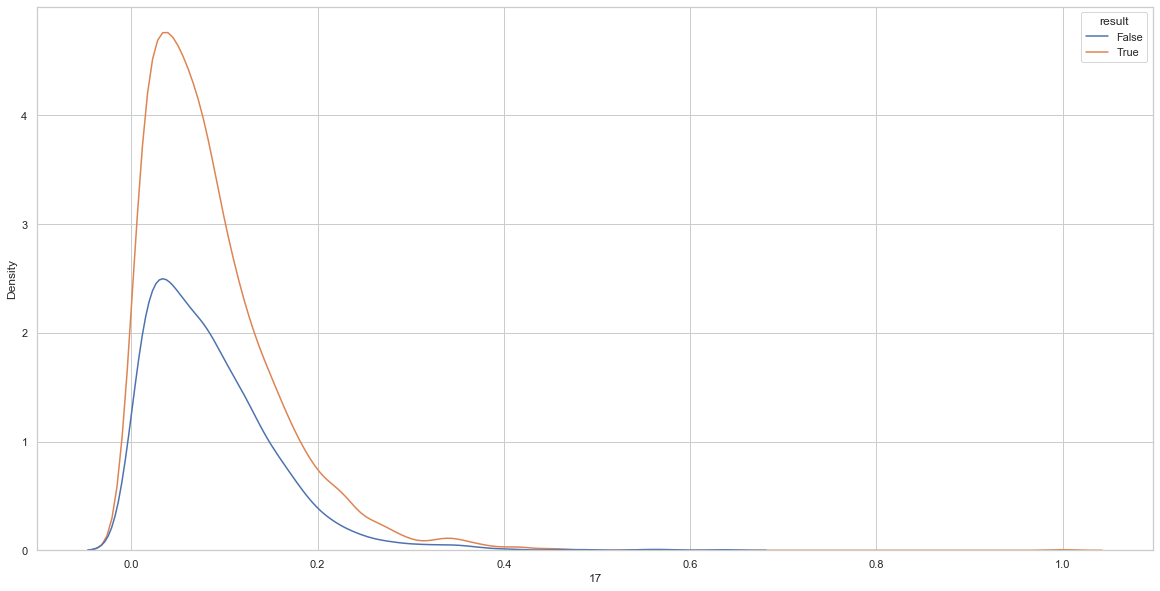

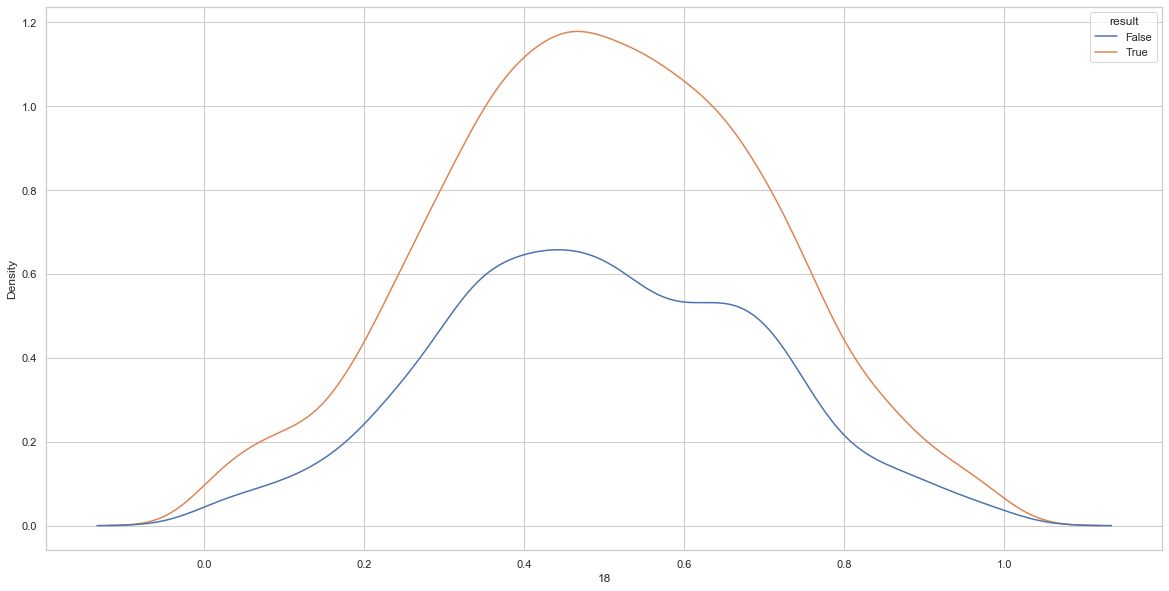

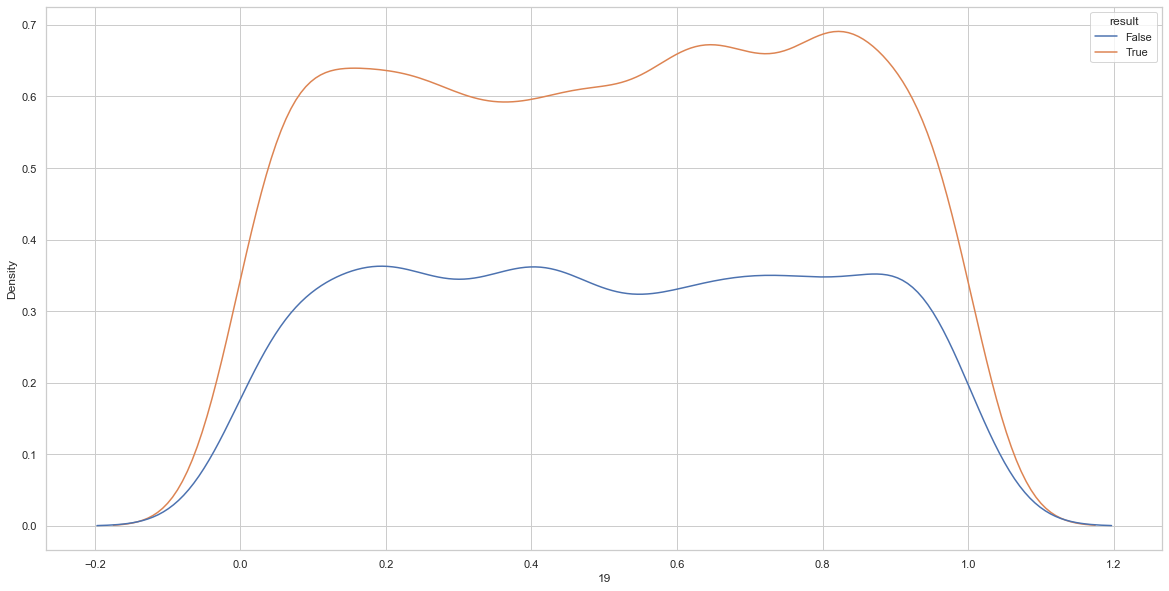

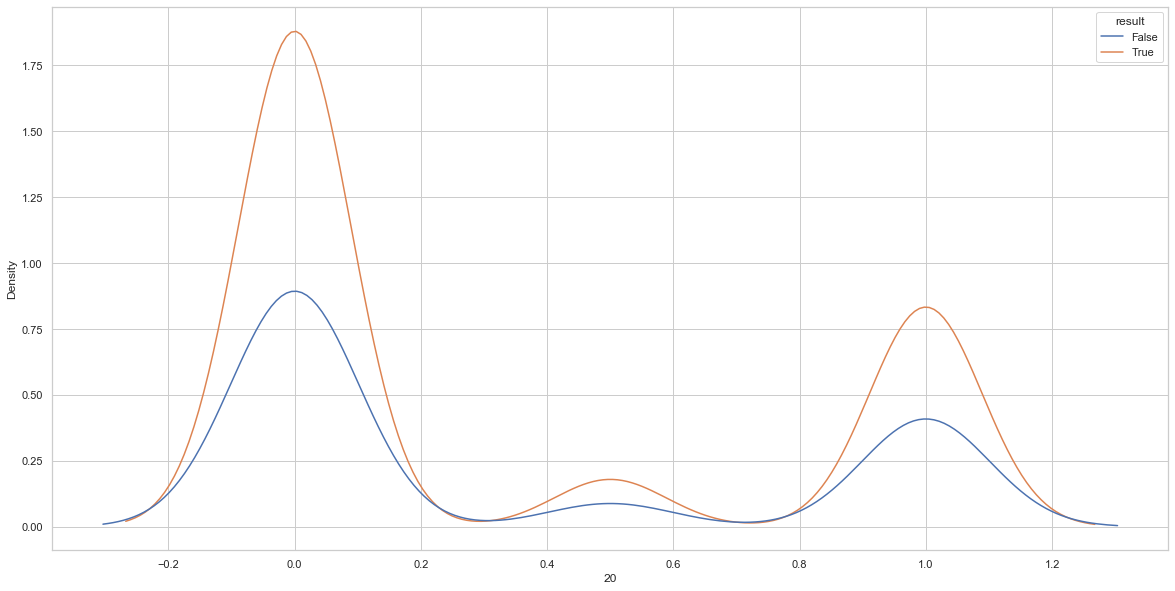

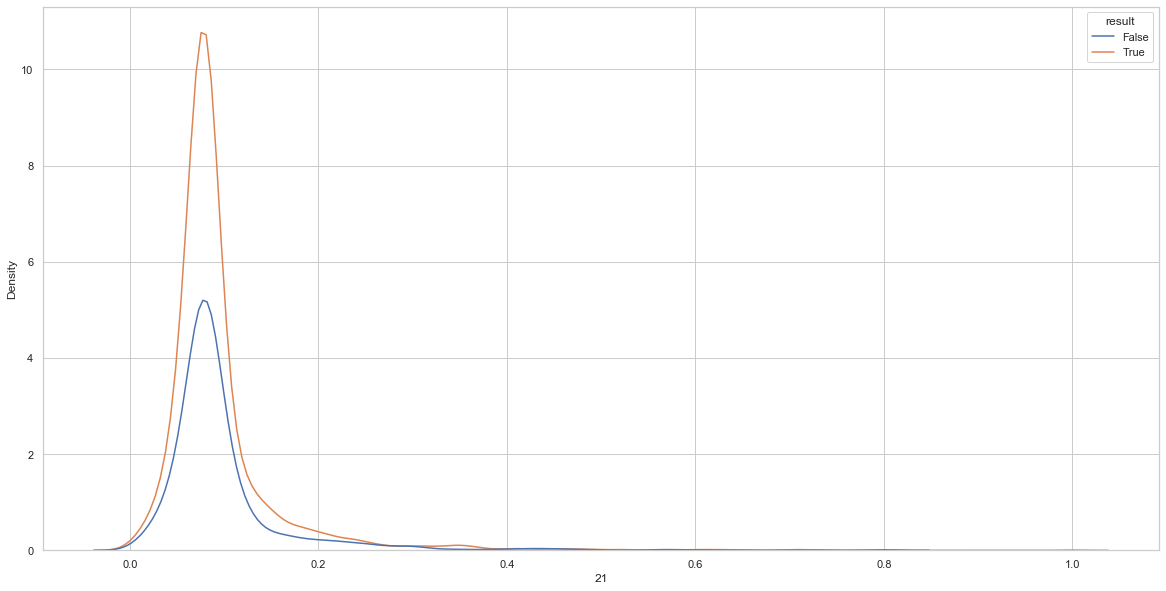

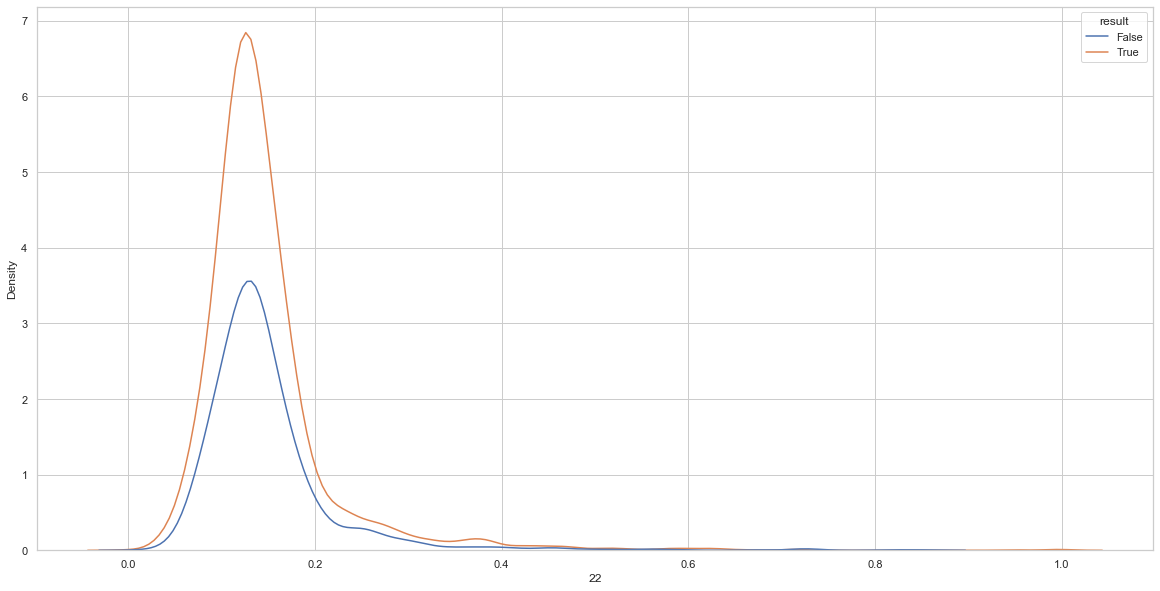

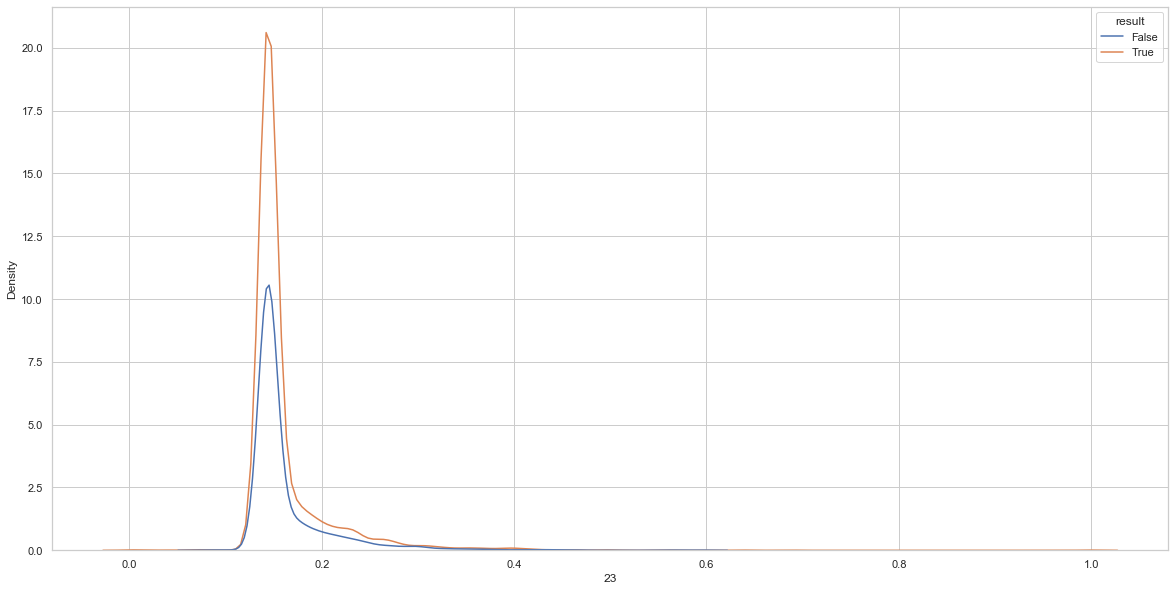

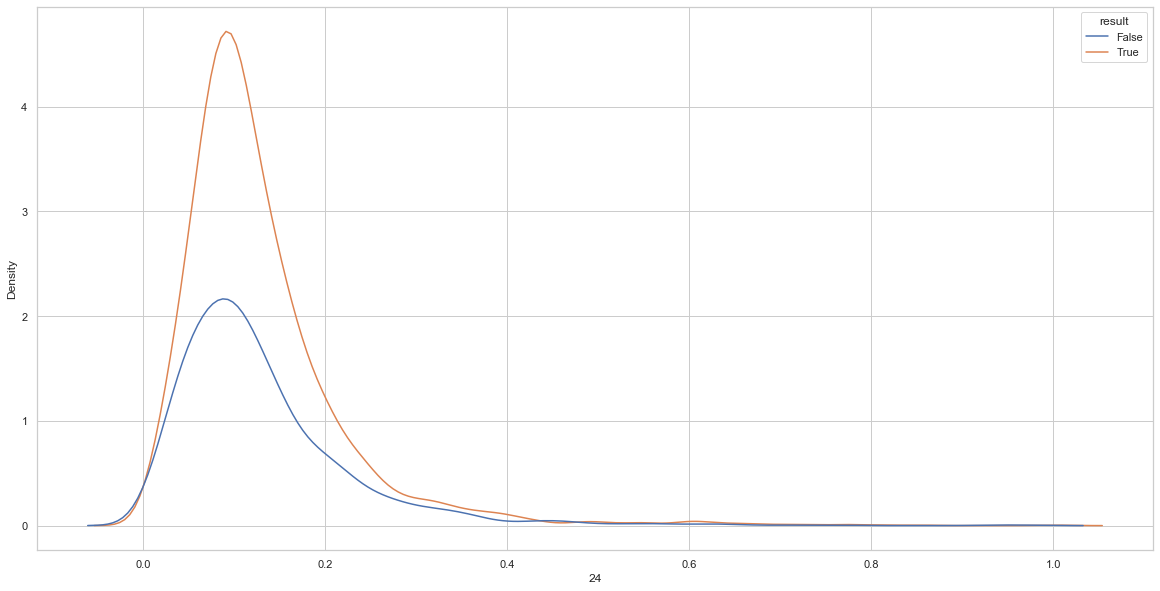

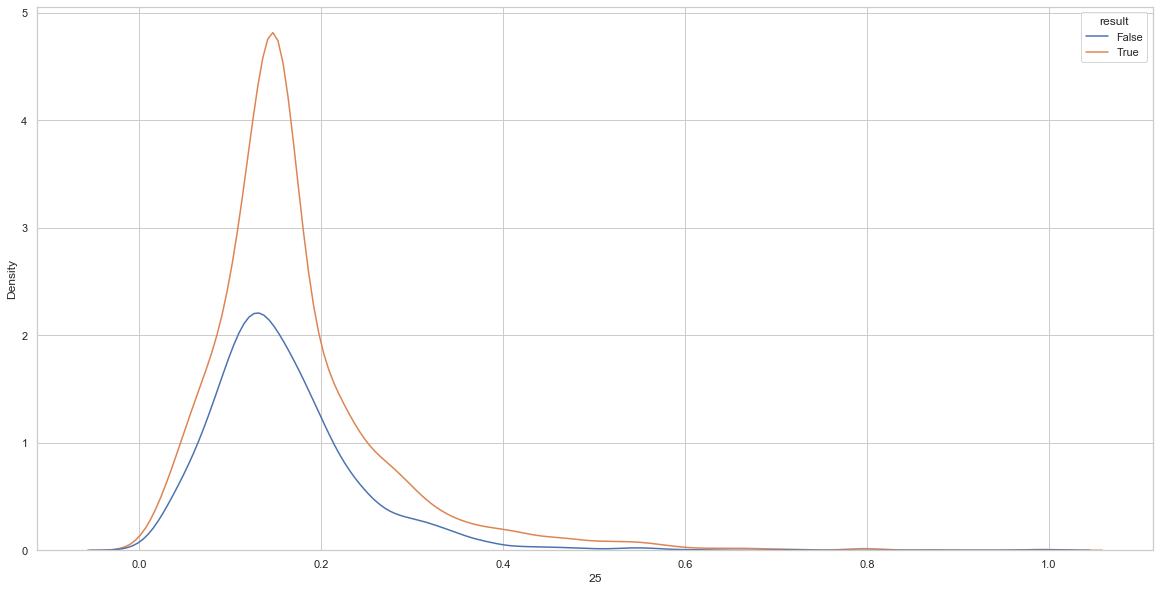

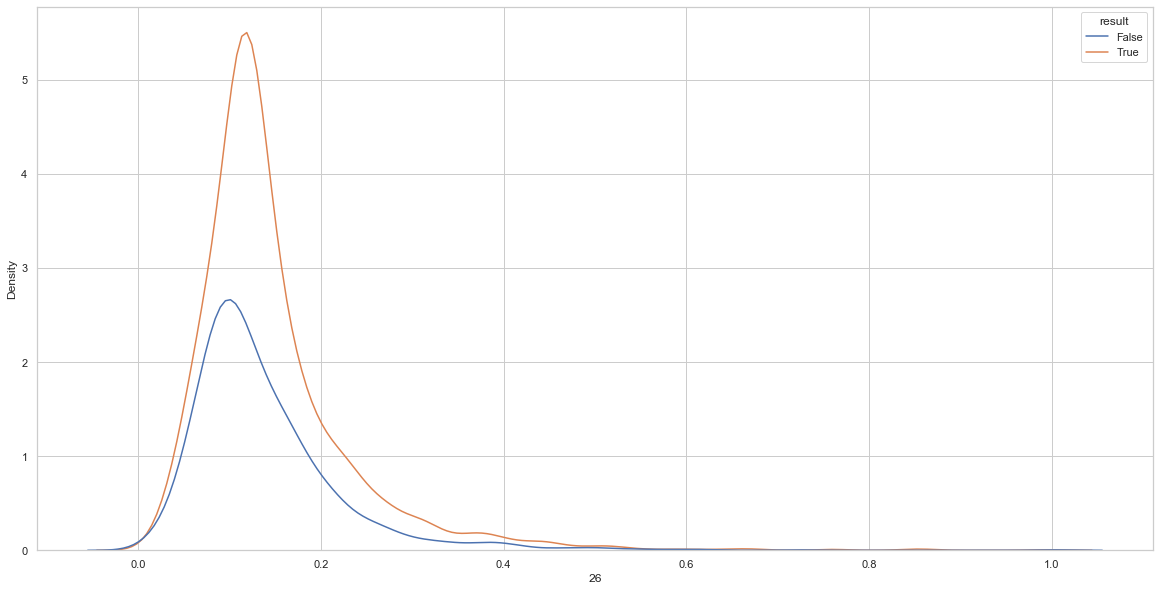

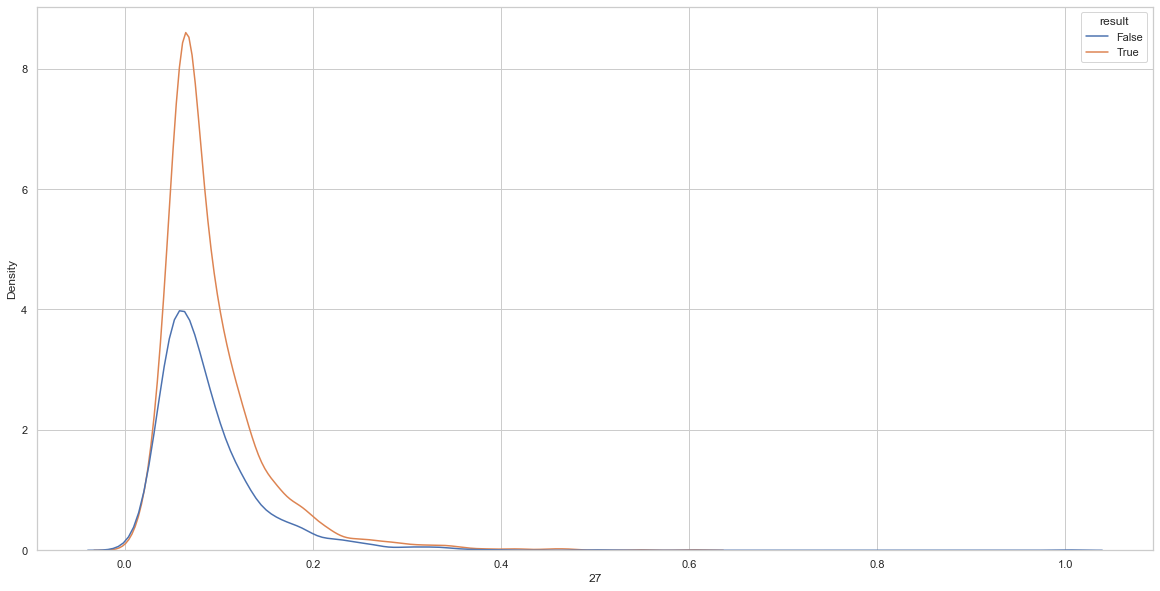

In [85]:
for column in result_data_df.columns[:-1]:
    sns.kdeplot(data=result_data_df, x=column, hue='result',alpha=0.5,  label = "Correct classifications")
    plt.show()

**3.2** Use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree with `max_depth=3` as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.



In [41]:
# Initialise the model with Decision Tree classifier as the base model same as above
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 3), 
                            algorithm = 'SAMME', n_estimators=800, learning_rate=0.05)

# Fit on the entire data
boost.fit(X_train,y_train)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

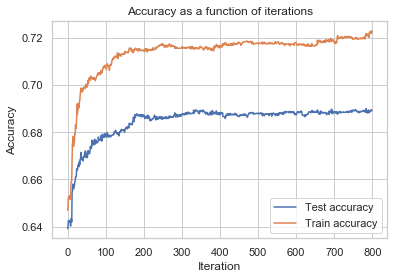

In [42]:
# plot accuracy by estimator
plt.plot(list(boost.staged_score(X_test,y_test)),label="Test accuracy")
plt.plot(list(boost.staged_score(X_train,y_train)),label="Train accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of iterations")
plt.legend()

**Comment:** Performance on test set does not improve materially after ~180 iterations.

**3.3** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)



In [43]:
boosts = []
boostfts = []
# build boost models with base estimators of different depths
for base_depth in [1, 2, 3, 4]:
    boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = base_depth), 
                                algorithm = 'SAMME', n_estimators=800, learning_rate=0.05)
    boosts.append(boost)


    # Fit on the entire data
    boostfit = boost.fit(X_train,y_train)
    boostfts.append(boostfit)

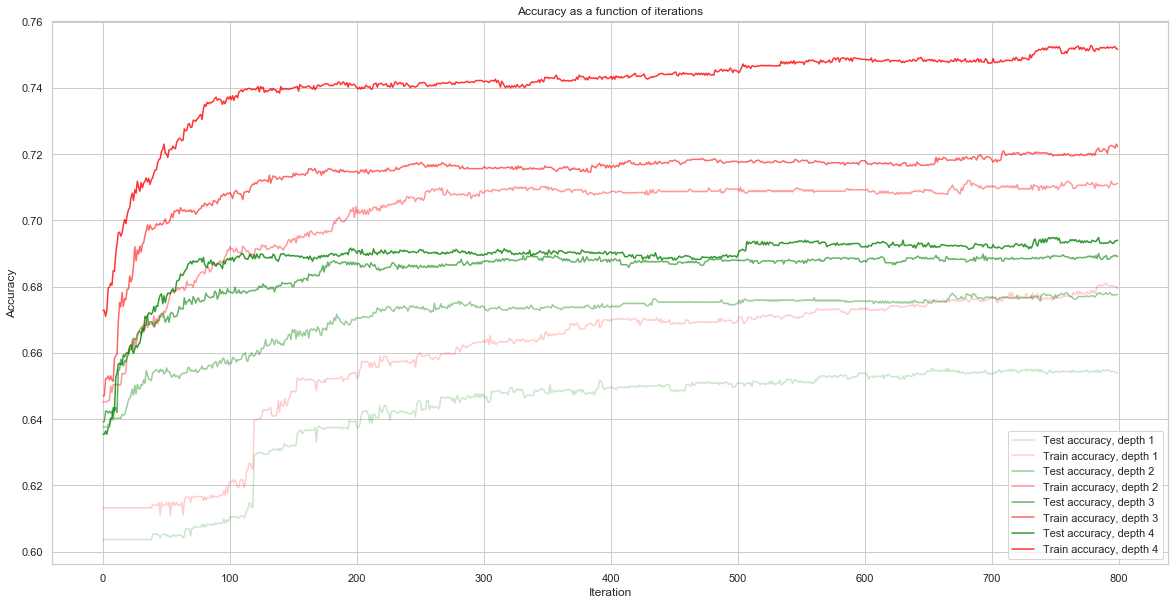

In [44]:
# plot accuracy by estimator for different base depths
plt.rcParams["figure.figsize"] = (20,10)
for base_depth in [1, 2, 3, 4]:
    plt.plot(list(boosts[base_depth -1].staged_score(X_test,y_test)),
             label="Test accuracy, depth " + str(base_depth), color = "green", alpha = base_depth/5)
    plt.plot(list(boosts[base_depth -1].staged_score(X_train,y_train)),
             label="Train accuracy, depth " + str(base_depth), color = "red", alpha = base_depth/5)
    plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of iterations")
plt.legend()

**Comment:** Depth for the base model has a material impact on accuracy. As depth goes up, accuracy increases. The effect, however, seems to flatten out on the test set around depth 4. Adding a deeper base estimator, increases accuracy on the training set, but limitedly on the test set.

**3.4** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?



**Comment:** 
The best model seems a model with a base learner of depth 4. At that depth accuracy on the test set is the highest for all iterations. Performers starts to flatten out around iteration 200. There's another small improvement around 500. Since a simpler model is better, 200 iterations is better than 500 iterations.

In [45]:
# limit the accuracy set to the first 200
train_list = list(boosts[base_depth -1].staged_score(X_train,y_train))[:200] 
test_list = list(boosts[base_depth -1].staged_score(X_test,y_test))[:200]

# assess which iteration is best
index_best_accuracy = test_list.index(max(test_list))
print("The iteration with the best accuracy in the first 200 iteratons is:", index_best_accuracy)

The iteration with the best accuracy in the first 200 iteratons is: 195


In [46]:
# Add best tree to comparison table
model_comparison_df.loc['Adaboost','training accuracy'] = train_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','test accuracy'] = test_list[index_best_accuracy]

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
classifier,,
Logistic,65.4%,62.9%
Logistic with interacton,71.0%,63.2%
Regularized logistic,65.4%,62.9%
Single tree,67.3%,63.5%
Bagging,69.7%,65.6%
Random forest,87.7%,68.9%
Adaboost,74.1%,69.2%


**Comment:** Adaboost added further accuracy to the model, hitting more than 69% on the test set.


**3.5** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**Comment:** Too many trees decreases bias but doesn't decrease variance.
Having too many trees also increases computational cost without generation value.

**3.6** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**Comment:** Bagging, including random forests, is much easier to parallelize as the results are based on majority votes or averages. Since boosting builds a new model on the residuals of the prevous model, it is iterative, and cannot be easily parallelized.

---

<div class='exercise'> <b> Question 4 [15 pts]: Model Comparison </b> </div>


**4.1**: Make a pandas table of the training and test accuracy for the following 5 models and name it `results_df`:

- The tuned L2-regularized logistic regression (from Question 1)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.


**4.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?


**4.3** Which of these techniques can be extended to regression tasks? How?

## Answers

**4.1**: Make a pandas table of the training and test accuracy for the following 6 models and name it `results_df`:

- The full logistic regression (from Question 1.3)
- The tuned L2-regularized logistic regression (from Question 1.4)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

---

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| logistic  | | |
| regularized logistic  | | |
| single tree  | | |
| bagging | | |
| random forest  | | |
| adaboost  | | |

In [47]:
# Add best tree to comparison table
results_df = model_comparison_df.copy()

results_df.loc['Adaboost','training accuracy'] = train_list[index_best_accuracy]
results_df.loc['Adaboost','test accuracy'] = test_list[index_best_accuracy]

# display the rates by model in percentage format
results_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
classifier,,
Logistic,65.4%,62.9%
Logistic with interacton,71.0%,63.2%
Regularized logistic,65.4%,62.9%
Single tree,67.3%,63.5%
Bagging,69.7%,65.6%
Random forest,87.7%,68.9%
Adaboost,74.1%,69.2%


**Comment:** Performance of all the logistic regressions is very smilar. A single tree is able to capture some more of the non-linear relationships. Bagging, random forest and Adaboost add further accuracy. Bagging models do so by leveraging results from multiple competing models. The boosting model works best as it explicity tries to improve on the previous model by modeling the residuals of the previous models. Note that the bagging and boosting models increase performance more on the train than on the test set.
@Sunil. We need more comments here on the bias-variance trade-off

**4.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?



Performance of all the logistic regressions is very smilar. A single tree is able to capture some more of the non-linear relationships. Bagging, random forest and Adaboost add further accuracy. Bagging models do so by leveraging results from multiple competing models. The boosting model works best as it explicity tries to improve on the previous model by modeling the residuals of the previous models. Note that the bagging and boosting models increase performance more on the train than on the test set.


**4.3** Which of these techniques can be extended to regression tasks? How?


All the techniques can be extended to regression tasks. 
For regression, we want to select a splitting criterion that promotes splits that improve the predictive accuracy of the model as measured by, say, overall MSE.
For regression, we want to label each region in the model with a real number - typically the average of the output values of the training points contained in the region.
 